In [1]:
import os
import anndata as ad
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from omicsdgd.functions._data_manipulation import load_testdata_as_anndata
from omicsdgd.dataset import omicsDataset
os.chdir('/Users/dbm829/Documents/work/Projects/GitHub/omicsDGD/')

matplotlib.rcParams.update({'font.size': 8})

## load data and model

### load data

In [2]:
# first find associated peaks
rna_ref_df = pd.read_csv('data/human_bonemarrow/gene_id_to_name.csv')
ref_df = pd.read_csv("data/human_bonemarrow/atac_peak_locations_closest_genes.csv")

In [3]:
modality_switch = len(rna_ref_df)
print(modality_switch)

13431


In [4]:
# import small data subsets and model
#data_prefix = './data/human_bonemarrow/subsets/'
data_name = "human_bonemarrow"
adata = ad.read_h5ad("data/" + data_name + ".h5ad")
train_indices = np.where(adata.obs["train_val_test"] == "train")[0]
trainset = adata[train_indices, :].copy()
test_indices = np.where(adata.obs["train_val_test"] == "test")[0]
testset = adata[test_indices, :].copy()
modality_switch = 13431
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense())[:, :modality_switch], dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense())[:, modality_switch:], dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)

### Load model

In [5]:
from omicsdgd import DGD
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_dir = './results/trained_models/human_bonemarrow/'
random_seed = 0
#fraction = 0.1

#dgd_name = 'human_bonemarrow_l20_h2-3_rs'+str(random_seed)+'_subset'+str(n_samples)
dgd_name = "human_bonemarrow_l20_h2-3_test50e"

model = DGD.load(data=trainset,
            save_dir=save_dir,
            model_name=dgd_name)
print('loaded model')

print(testset.shape)
print(model.test_rep.z.shape)


        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True
loaded model
(6925, 129921)
torch.Size([6925, 20])


In [ ]:
test_set = omicsDataset(
    testset,
    model.param_dict["modality_switch"],
    model.param_dict["scaling"],
    model.param_dict["clustering_variable(meta)"],
    model.param_dict["correction_variable"],
    model.param_dict["modalities"],
)

## define functions

In [35]:
def get_gene_ids(gene_name):
    gene_id = rna_ref_df[rna_ref_df["gene_name"] == gene_name]["gene_id"].values[0]
    gene_idx = np.where(rna_ref_df["gene_name"] == gene_name)[0][0]
    return gene_id, gene_idx

def find_closest_peak(gene_location):
    chrom = int(gene_location.split(":")[0].split("chr")[1])
    start = gene_location.split(":")[1].split("-")[0]
    end = gene_location.split(":")[1].split("-")[1]
    sub_df = ref_df[ref_df["Chromosome"] == chrom]
    # now find the peaks that contain the gene
    sub_df = sub_df[
        ((sub_df["Start"] <= int(start)) & (sub_df["End"] >= int(end))) | # peak contains gene
        ((sub_df["Start"] >= int(start)) & (sub_df["End"] <= int(end))) | # gene contains peak
        ((sub_df["Start"] <= int(start)) & (sub_df["End"] >= int(start))) | # peak starts before gene
        ((sub_df["Start"] <= int(end)) & (sub_df["End"] >= int(end))) # peak ends after gene
        ]
    closest_peak = list(sub_df['idx'].values)
    return closest_peak

def find_closest_start_and_end(chrom, window_start, window_end):
    sub_df = ref_df[ref_df["Chromosome"] == int(chrom.split("chr")[-1])]
    start_distances = np.abs(sub_df["Start"] - window_start)
    end_distances = np.abs(sub_df["End"] - window_end)
    start_idx = np.argmin(start_distances)
    end_idx = np.argmin(end_distances)
    return sub_df.iloc[start_idx]["idx"].item(), sub_df.iloc[end_idx]["idx"].item()

def plot_gel(heatmap, gene_name, gene_loc):
    df_heatmap_1 = pd.DataFrame(heatmap.numpy(), columns=testset.var.index[test_set.modality_switch+start_peak:test_set.modality_switch+end_peak], index=cell_types)
    df_heatmap_1 = df_heatmap_1.sort_index()

    fig, ax = plt.subplots(figsize=(20,5))
    sns.heatmap(df_heatmap_1, linewidth=0., cmap="RdBu_r", center=0)
    plt.title("prediction differences of peaks from {} gene silencing ({})".format(gene_name, gene_loc))
    plt.show()

    return df_heatmap_1

def plot_gel_subset(heatmap, cell_type_of_interest):
    df_heatmap_1 = pd.DataFrame(heatmap.numpy(), columns=testset.var.index[test_set.modality_switch+start_peak:test_set.modality_switch+end_peak], index=cell_types)
    df_heatmap_1 = df_heatmap_1.sort_index()
    # now select only the cell typse of interest
    df_heatmap_1 = df_heatmap_1[df_heatmap_1.index.isin(cell_type_of_interest)]

    fig, ax = plt.subplots(figsize=(20,5))
    sns.heatmap(df_heatmap_1, linewidth=0., cmap="RdBu_r", center=0)
    plt.title("prediction differences of peaks from CEBPB gene silencing")
    plt.show()

def insilico_hichip(df, celltypes_of_choice, bins, window_size=10000, norm=True, use_abs=True):
    # select data only for the cell types of interest
    df_cell = df.copy()[df.index.isin(celltypes_of_choice)]
    df_cell = df_cell.dropna()
    # get average and std of predicted differences
    df_cell_avg = df_cell.mean()
    df_cell_std = df_cell.std()

    # create data for evenly spaced bins of 10 kilobases
    bp_location_starts = []
    binned_kb_avg = []
    binned_kb_std = []
    # first go through the peaks
    for i in range(0, len(df_cell_avg)):
        location = df_cell_avg.index[i]
        start = int(location.split("-")[1])
        end = int(location.split("-")[2])
        # now loop through the bins
        for j in range(start, end, window_size):
            bp_location_starts.append(j)
            if use_abs:
                binned_kb_avg.append(abs(df_cell_avg[i]))
            else:
                binned_kb_avg.append(df_cell_avg[i])
            binned_kb_std.append(df_cell_std[i])
        # if j was still smaller than the end, add the end
        if j < end:
            bp_location_starts.append(end)
            if use_abs:
                binned_kb_avg.append(abs(df_cell_avg[i]))
            else:
                binned_kb_avg.append(df_cell_avg[i])
            binned_kb_std.append(df_cell_std[i])
        # if the next peak is not directly after this one, add zeros until the begin of the next peak
        if i < len(df_cell_avg)-1:
            next_start = int(df_cell_avg.index[i+1].split("-")[1])
            if end+window_size < next_start:
                for j in range(end+window_size, next_start, window_size):
                    bp_location_starts.append(j)
                    binned_kb_avg.append(0)
                    binned_kb_std.append(0)
    
    # normalize the values
    binned_kb_avg = np.array(binned_kb_avg)
    binned_kb_std = np.array(binned_kb_std)
    if norm:
        binned_kb_avg = (binned_kb_avg - np.min(binned_kb_avg)) / (np.max(binned_kb_avg) - np.min(binned_kb_avg))
        binned_kb_std = (binned_kb_std - np.min(binned_kb_std)) / (np.max(binned_kb_std) - np.min(binned_kb_std))
    
    # return bp_location_starts, binned_kb_avg, binned_kb_std

    # now match the binned data with the provided bins (average if multiple peaks were in one reference bin)
    binned_kb_avg_matched = []
    binned_kb_std_matched = []
    for i in range(0, len(bins)):
        # get the indices of the binned data that are in the reference bin
        if i == len(bins)-1:
            indices = np.where(np.array(bp_location_starts) >= bins[i])[0]
        else:
            indices = np.where(np.logical_and(np.array(bp_location_starts) >= bins[i], np.array(bp_location_starts) < bins[i+1]))[0]
        # if there are no indices, add a zero
        if len(indices) == 0:
            #print('error')
            #print(i, bins[i], len(bins))
            binned_kb_avg_matched.append(0)
            binned_kb_std_matched.append(0)
        # if there are indices, average the values
        else:
            binned_kb_avg_matched.append(np.mean(binned_kb_avg[indices]))
            binned_kb_std_matched.append(np.mean(binned_kb_std[indices]))
            #binned_kb_avg_matched.append(np.max(binned_kb_avg[indices]))
            #binned_kb_std_matched.append(np.max(binned_kb_std[indices]))
    return bins, binned_kb_avg_matched, binned_kb_std_matched

def normalize_hichip(hichip_eis, scaling_factor=10):
    hichip_eis = (hichip_eis - np.min(hichip_eis)) / (np.max(hichip_eis) - np.min(hichip_eis))
    return hichip_eis * scaling_factor

def prepare_df_emma(file_dir):
    df_emma = pd.read_csv(file_dir, sep=",")
    sample_names = df_emma.sample_name.unique()
    dfs_emma = []
    for i, sample_name in enumerate(sample_names):
        df_emma_sample = df_emma[df_emma.sample_name == sample_name].loc[:, ["position", "EIS", "sample_name"]]
        #df_emma_sample["sample_name"] = [s.split("_")[0] for s in df_emma_sample["sample_name"].values]
        df_emma_sample.columns = ["position", "signal", "cell type"]
        if i == 0:
            df_emma_out = df_emma_sample
        else:
            df_emma_out = pd.concat([df_emma_out, df_emma_sample])
    df_emma_out['std'] = 0
    df_emma_out['method'] = 'HiChIP'
    return df_emma_out

from scipy.stats import spearmanr

def gene_correlation(gene_values, df, celltypes_of_choice, bins, window_size=10000, norm=True, use_abs=True):
    # select data only for the cell types of interest
    df_cell = df.copy()[df.index.isin(celltypes_of_choice)]
    df_cell = df_cell.dropna()
    # get correlation between gene and peaks (spearman)
    df_cell_corr = df_cell.apply(lambda x: spearmanr(gene_values, x.values)[0], axis=0)
    df_cell_std = df_cell.apply(lambda x: spearmanr(gene_values, x.values)[1], axis=0)

    # create data for evenly spaced bins of 10 kilobases
    bp_location_starts = []
    binned_kb_avg = []
    binned_kb_std = []
    # first go through the peaks
    for i in range(0, len(df_cell_corr)):
        location = df_cell_corr.index[i]
        start = int(location.split("-")[1])
        end = int(location.split("-")[2])
        # now loop through the bins
        for j in range(start, end, window_size):
            bp_location_starts.append(j)
            if use_abs:
                binned_kb_avg.append(abs(df_cell_corr[i]))
            else:
                binned_kb_avg.append(df_cell_corr[i])
            binned_kb_std.append(df_cell_std[i])
        # if j was still smaller than the end, add the end
        if j < end:
            bp_location_starts.append(end)
            if use_abs:
                binned_kb_avg.append(abs(df_cell_corr[i]))
            else:
                binned_kb_avg.append(df_cell_corr[i])
            binned_kb_std.append(df_cell_std[i])
        # if the next peak is not directly after this one, add zeros until the begin of the next peak
        if i < len(df_cell_corr)-1:
            next_start = int(df_cell_corr.index[i+1].split("-")[1])
            if end+window_size < next_start:
                for j in range(end+window_size, next_start, window_size):
                    bp_location_starts.append(j)
                    binned_kb_avg.append(0)
                    binned_kb_std.append(0)
    
    # normalize the values
    binned_kb_avg = np.array(binned_kb_avg)
    binned_kb_std = np.array(binned_kb_std)
    if norm:
        binned_kb_avg = (binned_kb_avg - np.min(binned_kb_avg)) / (np.max(binned_kb_avg) - np.min(binned_kb_avg))
        binned_kb_std = (binned_kb_std - np.min(binned_kb_std)) / (np.max(binned_kb_std) - np.min(binned_kb_std))
    
    # return bp_location_starts, binned_kb_avg, binned_kb_std

    # now match the binned data with the provided bins (average if multiple peaks were in one reference bin)
    binned_kb_avg_matched = []
    binned_kb_std_matched = []
    for i in range(0, len(bins)):
        # get the indices of the binned data that are in the reference bin
        if i == len(bins)-1:
            indices = np.where(np.array(bp_location_starts) >= bins[i])[0]
        else:
            indices = np.where(np.logical_and(np.array(bp_location_starts) >= bins[i], np.array(bp_location_starts) < bins[i+1]))[0]
        # if there are no indices, add a zero
        if len(indices) == 0:
            #print('error')
            #print(i, bins[i], len(bins))
            binned_kb_avg_matched.append(0)
            binned_kb_std_matched.append(0)
        # if there are indices, average the values
        else:
            binned_kb_avg_matched.append(np.mean(binned_kb_avg[indices]))
            binned_kb_std_matched.append(np.mean(binned_kb_std[indices]))
            #binned_kb_avg_matched.append(np.max(binned_kb_avg[indices]))
            #binned_kb_std_matched.append(np.max(binned_kb_std[indices]))
    return bins, binned_kb_avg_matched, binned_kb_std_matched

def plot_roc_curves(df_c, df_p, c_1, c_2, p_1, p_2, mode='prediction'):
    # now make ROC curves for the dgd predictions
    from sklearn.metrics import roc_curve, auc

    pos_color = 'cornflowerblue'
    neg_color = 'lightcoral'
    correction_color = 'slategray'

    # drop duplicates
    df_c = df_c.drop_duplicates()
    df_p = df_p.drop_duplicates()

    # create 2 subplots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    # adjust spacing
    fig.subplots_adjust(wspace=0.9)

    # first get the values for the same positions
    x, y = df_c[df_c['cell type']==c_1], df_p[df_p['cell type']==p_1]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    ax[0].plot(fpr, tpr, pos_color, label=f'HiChIP Naive CD4+ T\nAUPRC = {np.round(auprc, 3)}')

    x, y = df_c[df_c['cell type']==c_2], df_p[df_p['cell type']==p_1]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, neg_color, label=f'HiChIP HCASMC (neg control)\nAUPRC = {np.round(auprc, 3)}')
    ax[0].axline((min(fpr), min(tpr)), slope=1, color="grey", linestyle=':')
    ax[0].set_xlabel("False positive rate")
    ax[0].set_ylabel("True positive rate")
    if mode == 'prediction':
        ax[0].set_title("DGD prediction ({})".format(p_1))
    else:
        ax[0].set_title("Baseline correlation ({})".format(p_1))
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)


    x, y = df_c[df_c['cell type']==c_1], df_p[df_p['cell type']==p_2]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, pos_color, label=f'HiChIP Naive CD4+ T\nAUPRC = {np.round(auprc, 3)}')
    
    x, y = df_c[df_c['cell type']==c_2], df_p[df_p['cell type']==p_2]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, neg_color, label=f'HiChIP HCASMC (neg control)\nAUPRC = {np.round(auprc, 3)}')
    ax[1].axline((min(fpr), min(tpr)), slope=1, color="grey", linestyle=':')
    ax[1].set_xlabel("False positive rate")
    ax[1].set_ylabel("True positive rate")
    if mode == 'prediction':
        ax[1].set_title("DGD prediction ({})".format(p_2))
    else:
        ax[1].set_title("Baseline correlation ({})".format(p_2))
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)
    plt.show()

    return optimal_threshold

# 1. Can the model find connections like HiChIP?

## Gene: ID2

In [80]:
gene_name = "ID2"
gene_location = "chr2:8678845-8684461"

file_dir = "./results/analysis/analysis_referencedata/EIS_signal_"+gene_name+"promoter.hg38.csv"
gene_id, gene_idx = get_gene_ids(gene_name)
peak_ids = find_closest_peak(gene_location)
print("Gene ID is {} at index {}, peak positions are {}".format(gene_id, gene_idx, peak_ids))

Gene ID is ENSG00000115738 at index 1363, peak positions are [57601, 57602, 57603]


In [81]:
#print the gene locations of the two closest peak_ids
print("The closest peaks are located at:")
for peak_id in peak_ids:
    print(peak_id, testset.var.index[peak_id + modality_switch])

The closest peaks are located at:
57601 chr2-8678492-8679388
57602 chr2-8681545-8682416
57603 chr2-8684437-8685251


here the promoter region of the gene is covered and a medium/end part

using 1938 samples


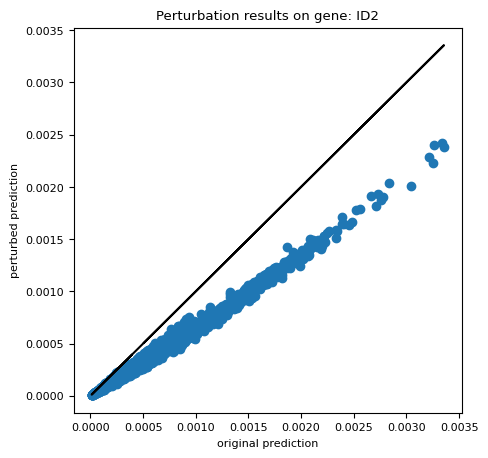

In [82]:
predicted_changes, samples_of_interest = model.gene2peak(gene_name=gene_name, testset=testset, plot=True)

In [23]:
from omicsdgd.functions._gene_to_peak_linkage import predict_perturbations
def gene2peak(model, gene_name, testset, gene_ref=None, plot=False, quantile=None):
        if gene_name not in testset.var_names:
            if gene_ref is not None:
                if isinstance(gene_ref, str):
                    gene_ref = testset.var[gene_ref]
                else:
                    raise ValueError("gene_ref must be a string")
            else:
                raise ValueError("Gene was not found in data. It might be spelled wrong or you need to specify the var column name that contains the gene name.")
        else:
            gene_ref = testset.var_names
        gene_id = np.where(gene_ref == gene_name)[0][0]
        predictions_original_gene, predictions_upregulated_gene, samples_of_interest = predict_perturbations(model, testset, gene_id)
        
        # plot the results
        if plot:
            if quantile is None:
                fig, ax = plt.subplots(figsize=(5,5))
                plt.plot(predictions_original_gene[0][:,gene_id], predictions_original_gene[0][:,gene_id], color="black")
                plt.scatter(predictions_original_gene[0][:,gene_id], predictions_upregulated_gene[0][:,gene_id])
                plt.xlabel("original prediction")
                plt.ylabel("perturbed prediction")
                plt.title("Perturbation results on gene: " + gene_name)
                plt.show()
            else:
                fig, ax = plt.subplots(figsize=(5,5))
                plt.plot(predictions_original_gene[0][:,gene_id], predictions_original_gene[0][:,gene_id], color="black")
                quantile_val = np.quantile(predictions_original_gene[0][:,gene_id], quantile)
                samples_in_quantile = np.where(predictions_original_gene[0][:,gene_id] < quantile_val)[0]
                samples_outside_quantile = np.where(predictions_original_gene[0][:,gene_id] >= quantile_val)[0]
                plt.scatter(predictions_original_gene[0][samples_in_quantile,gene_id], predictions_upregulated_gene[0][samples_in_quantile,gene_id], color="red")
                plt.scatter(predictions_original_gene[0][samples_outside_quantile,gene_id], predictions_upregulated_gene[0][samples_outside_quantile,gene_id], color="blue")
                plt.xlabel("original prediction")
                plt.ylabel("perturbed prediction")
                plt.title("Perturbation results on gene: " + gene_name)
        predicted_changes = [(predictions_upregulated_gene[i] - predictions_original_gene[i]) for i in range(len(model.train_set.modalities))]
        if quantile is not None:
            predicted_changes = [predicted_changes[i][samples_outside_quantile,:] for i in range(len(model.train_set.modalities))]
            samples_of_interest = samples_of_interest[samples_outside_quantile]
        return predicted_changes, samples_of_interest

using 1938 samples


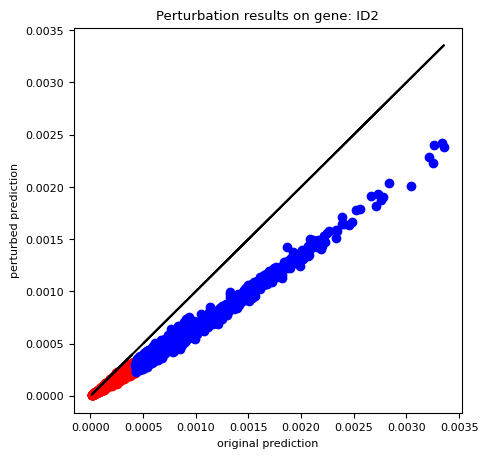

In [10]:
predicted_changes, samples_of_interest = model.gene2peak(gene_name=gene_name, testset=testset, plot=True, quantile=0.5)

### look at responses of all data sorted by cell type

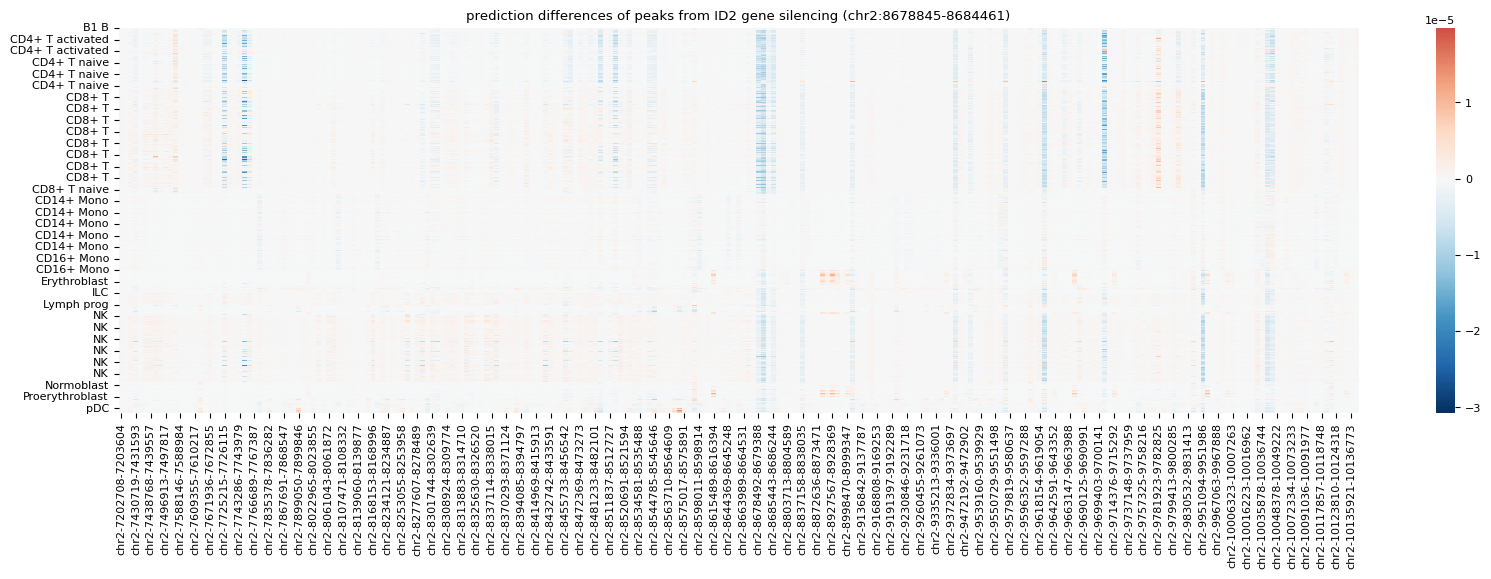

In [83]:
gene_chromosome = gene_location.split(":")[0]
window_start = int(gene_location.split(":")[1].split("-")[0]) - 1500000
window_end = int(gene_location.split(":")[1].split("-")[1]) + 1500000
# find the closest start and end peaks to the window start and end
start_peak, end_peak = find_closest_start_and_end(gene_chromosome, window_start, window_end)

cell_types = testset.obs['cell_type'].values[samples_of_interest]
heatmap_1 = predicted_changes[1][:,start_peak:end_peak]

df_heatmap_1 = plot_gel(heatmap_1, gene_name, gene_location)

In [84]:
cell_types_unique, cell_types_numbers = df_heatmap_1.index.value_counts().index.values, df_heatmap_1.index.value_counts().values

In [85]:
# plot the response in emma's window per cell type

window_size = 10000

df_hichip = prepare_df_emma(file_dir)
df_pos_intersect = np.sort(df_hichip['position'].unique())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = insilico_hichip(df_heatmap_1, [ct], bins=df_pos_intersect, window_size=window_size, norm=False, use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'multiDGD'
    })
    if i == 0:
        df_open_closed = df_open_closed_temp
    else:
        df_open_closed = pd.concat([df_open_closed, df_open_closed_temp], axis=0)

df_open_closed = pd.concat([df_open_closed, df_hichip], axis=0)
df_open_closed['position'] = df_open_closed['position'].values / 1e6
# reindex from 0
df_open_closed = df_open_closed.reset_index(drop=True)
df_open_closed

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_1296/3221838582.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pos = df_pos.groupby(['position']).mean().reset_index()
/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_1296/3221838582.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['sample_name'] = 'negative'


position        signal           std cell type    method
0      7.189869  0.000000e+00  0.000000e+00    CD8+ T  multiDGD
1      7.199869  3.553820e-07  2.130216e-07    CD8+ T  multiDGD
2      7.209869  0.000000e+00  0.000000e+00    CD8+ T  multiDGD
3      7.219869  0.000000e+00  0.000000e+00    CD8+ T  multiDGD
4      7.229869  0.000000e+00  0.000000e+00    CD8+ T  multiDGD
...         ...           ...           ...       ...       ...
6892  10.049873  1.140539e-01  0.000000e+00  negative    HiChIP
6893  10.059873  1.140539e-01  0.000000e+00  negative    HiChIP
6894  10.069873  2.281078e-01  0.000000e+00  negative    HiChIP
6895  10.099873  1.140539e-01  0.000000e+00  negative    HiChIP
6896  10.119873  6.843235e-01  0.000000e+00  negative    HiChIP

[6897 rows x 5 columns]

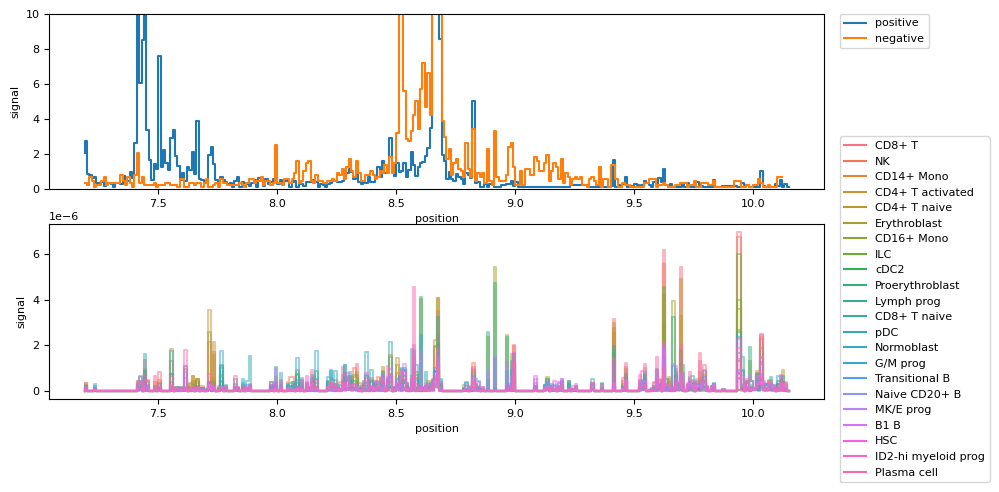

In [86]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
sns.lineplot(x='position', y='signal', data=df_open_closed[df_open_closed['method']=='HiChIP'], hue='cell type', ax=ax[0], drawstyle='steps-pre')
ax[0].set_ylim(0,10)
ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0.)
sns.lineplot(x='position', y='signal', data=df_open_closed[df_open_closed['method']=='multiDGD'], hue='cell type', ax=ax[1], alpha=0.5, drawstyle='steps-pre')
ax[1].legend(bbox_to_anchor=(1.02, 1.5), loc=2, borderaxespad=0.)
plt.show()

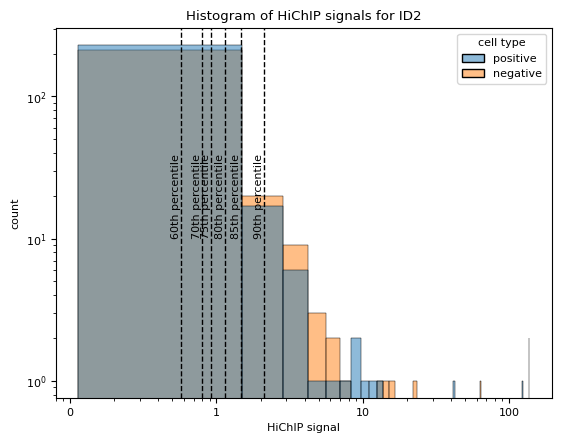

In [87]:
# plot histograms of the hichip values
from matplotlib.ticker import ScalarFormatter

sns.histplot(data=df_open_closed[df_open_closed['method']=='HiChIP'], x='signal', hue='cell type', bins=100, alpha=0.5)
# add lines for some percentiles
percentiles = [60, 70, 75, 80, 85, 90]
for p in percentiles:
    plt.axvline(x=np.percentile(df_open_closed[df_open_closed['method']=='HiChIP']['signal'], p), color='black', linestyle='--', lw=1)
    plt.text(np.percentile(df_open_closed[df_open_closed['method']=='HiChIP']['signal'], p), 10, str(p)+'th percentile', rotation=90, va='bottom', ha='right')
plt.yscale('log')
plt.xscale('log')
# make the axis ticks normal numbers instead of scientific notation
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('HiChIP signal')
plt.ylabel('count')
plt.title('Histogram of HiChIP signals for ID2')
plt.show()

In [88]:
# get the 75th percentile of the hichip signals to have something to compare to for binarized data
df_open_closed_hichip = df_open_closed[df_open_closed['method']=='HiChIP'].copy()
thresh_hichip = df_open_closed_hichip['signal'].quantile(0.75)
print(thresh_hichip)

df_pos_intersect = np.sort(df_open_closed['position'].unique())

# now subset the data to these positions
#df_open_closed_hichip = df_open_closed_hichip[df_open_closed_hichip['position'].isin(df_pos_intersect)]

# now binarize the data
df_open_closed_binary_hichip = df_open_closed_hichip.copy()
df_open_closed_binary_hichip['signal'] = df_open_closed_binary_hichip['signal'].apply(lambda x: 1 if x > thresh_hichip else 0)
df_open_closed_binary_dgd = df_open_closed[df_open_closed['method']=='multiDGD'].copy()
# select the valid positions
#df_open_closed_binary_dgd = df_open_closed_binary_dgd[df_open_closed_binary_dgd['position'].isin(df_pos_intersect)]

0.912431340967266


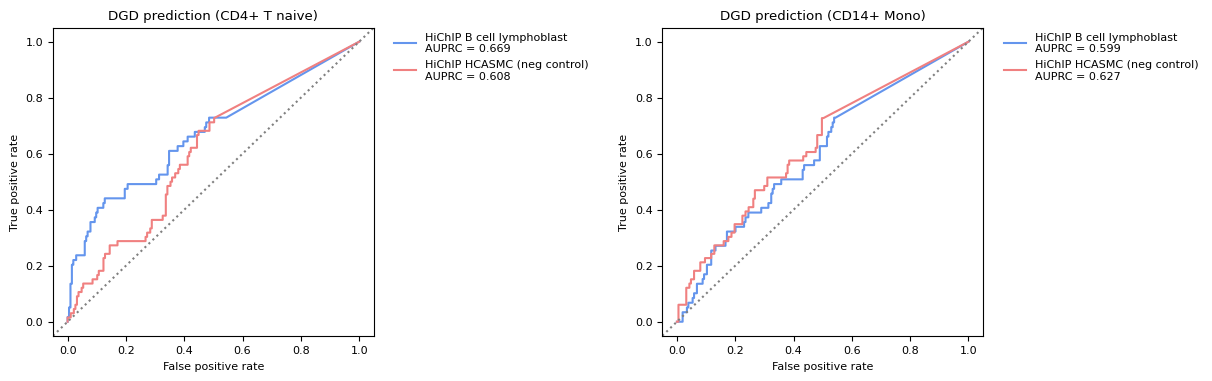

1.773600999399605e-07

In [90]:
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'CD4+ T naive', 'CD14+ Mono')
optimal_threshold

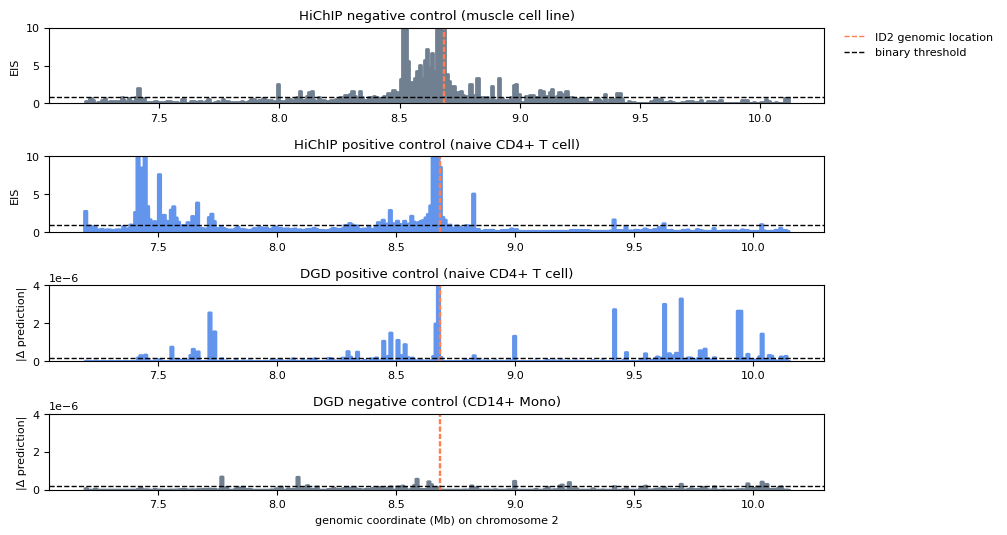

In [91]:
negative_control = 'CD14+ Mono'

# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions
gene_start = int(gene_location.split(":")[1].split("-")[0])/1e6
gene_end = int(gene_location.split(":")[1].split("-")[1])/1e6
thresh_dgd = optimal_threshold
thresholds = [thresh_hichip, thresh_hichip, thresh_dgd, thresh_dgd]
ylims = [10,10,4e-6,4e-6]
#ylims = [10,10,0.01,0.01]
#ylims = [20,20,1e-5,1e-5]
ylabels = ['EIS','EIS','|Δ prediction|', '|Δ prediction|']
color_pos = 'cornflowerblue'
color_neg = 'slategray'
gene_color = 'coral'
gene_alpha = 1

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,6))
# adjust spacing
fig.subplots_adjust(hspace=0.7)

ax[0].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='negative')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='negative')]['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[0].set_title('HiChIP negative control (muscle cell line)')


ax[1].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='positive')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='positive')]['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[1].set_title('HiChIP positive control (naive CD4+ T cell)')

ax[2].fill_between(
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']=='CD4+ T naive')]['position'],
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']=='CD4+ T naive')]['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[2].set_title('DGD positive control (naive CD4+ T cell)')

ax[3].fill_between(
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']==negative_control)]['position'],
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']==negative_control)]['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[3].set_title('DGD negative control ('+negative_control+')')

for i in range(4):
    #ax[i].set_yscale('log')
    #ax[i].set_xlim(7.3,10.1)
    ax[i].axvline(x=gene_start, color=gene_color, linestyle='--', lw=1, label=gene_name+' genomic location')
    ax[i].axvline(x=gene_end, color=gene_color, linestyle='--', lw=1)
    ax[i].set_ylim(0,ylims[i])
    ax[i].axhline(y=thresholds[i], color='black', linestyle='--', lw=1, label='binary threshold')
    ax[i].set_ylabel(ylabels[i])
    if i < 3:
        ax[i].set_xlabel('')
    else:
        ax[3].set_xlabel('genomic coordinate (Mb) on chromosome '+gene_location.split(':')[0].split('chr')[1])

ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0., frameon=False)

#caption = 'In silico gene-to-peak linkage of ID2'
#fig.text(.51, 1.005, caption, ha='center', fontsize=10, fontweight='bold')

plt.show()

In [92]:
# save the dataframe
df_open_closed.to_csv('./results/analysis/analysis_referencedata/'+gene_name+'_hg38_hichip_dgd_aligned_locations.csv', index=False)

#### baseline correlation

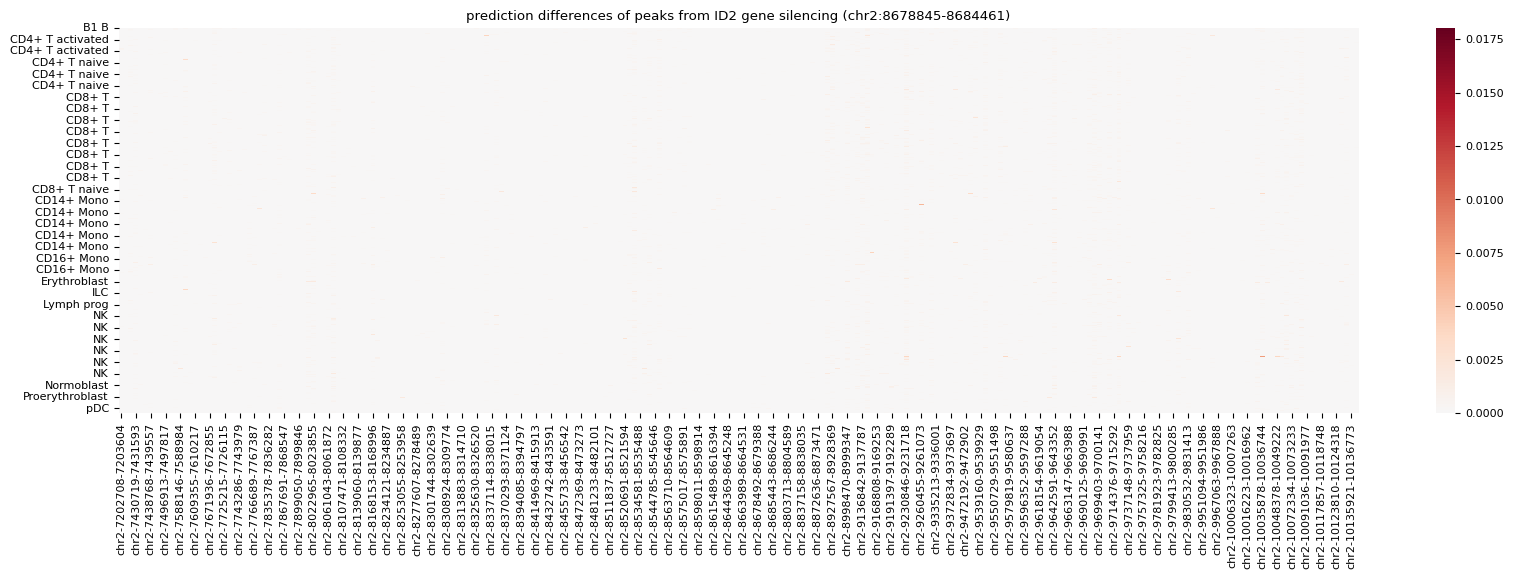

In [93]:
# now for normalized cell counts (divided by count depth of cell)

gex_count_depth = testset.obs['GEX_n_counts'].values[samples_of_interest]
atac_count_depth = testset.obs['ATAC_nCount_peaks'].values[samples_of_interest]

heatmap_control = torch.tensor(np.array(testset.X[samples_of_interest, start_peak:end_peak].todense())) / torch.tensor(atac_count_depth).unsqueeze(1)
df_heatmap_control = plot_gel(heatmap_control, gene_name, gene_location)

In [94]:
gene_counts = np.array(testset.X[samples_of_interest, gene_idx].todense())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = gene_correlation(
        gene_counts[np.where(testset[samples_of_interest].obs['cell_type'] == ct)[0]], 
        df_heatmap_control, 
        [ct], 
        bins=df_pos_intersect*1e6, 
        window_size=window_size, 
        norm=False, 
        use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'Spearman'
    })
    if i == 0:
        df_open_closed_control = df_open_closed_temp
    else:
        df_open_closed_control = pd.concat([df_open_closed_control, df_open_closed_temp], axis=0)

df_open_closed_control
df_open_closed_control.index = np.arange(len(df_open_closed_control))
df_open_closed_control['position'] = df_open_closed_control['position'] / 1e6

/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the

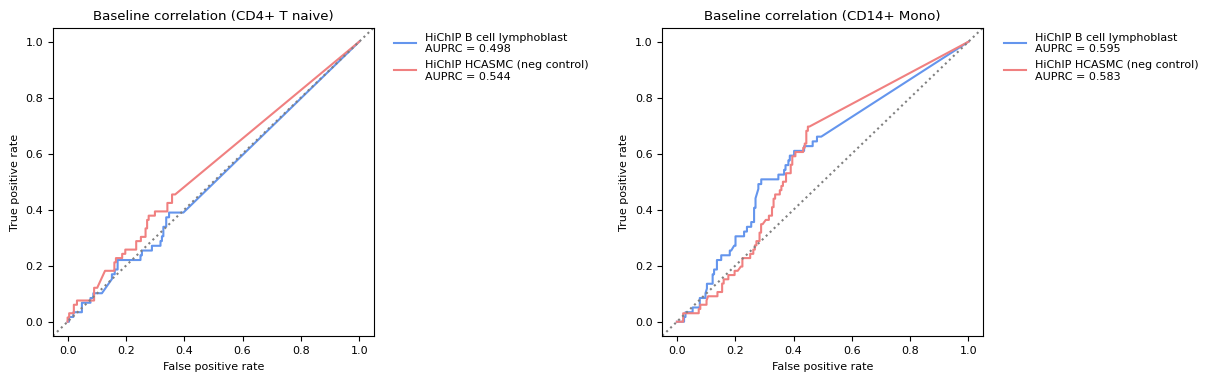

0.07067676684319749

In [95]:
df_open_closed_control.fillna(0, inplace=True)

optimal_threshold_baseline = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_control, 'positive', 'negative', 'CD4+ T naive', 'CD14+ Mono', mode='baseline')
optimal_threshold_baseline

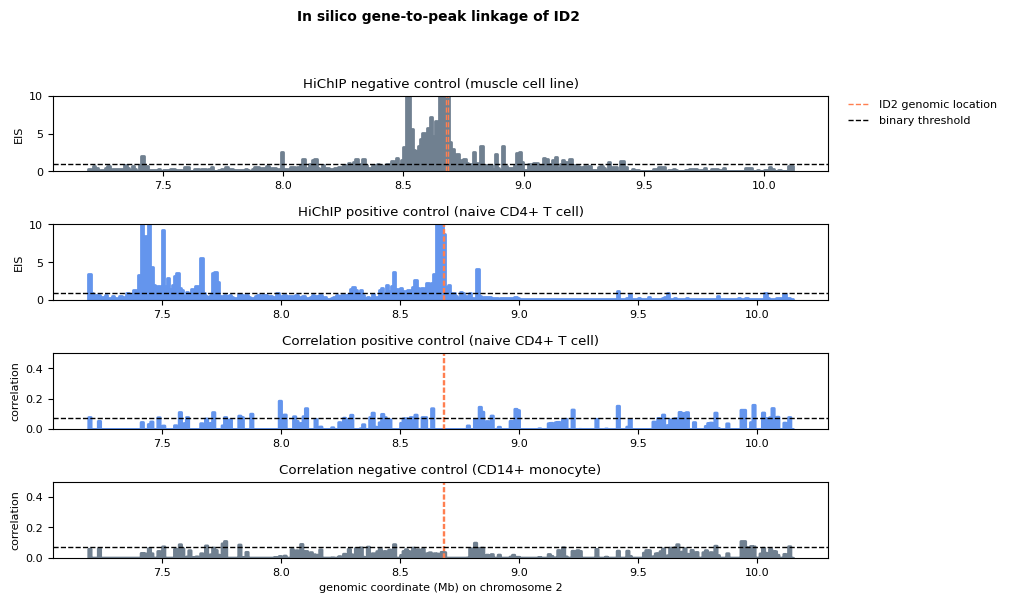

In [44]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions
ylims = [10,10,0.5,0.5]
ylabels = ['EIS','EIS','correlation', 'correlation']
color_pos = 'cornflowerblue'
color_neg = 'slategray'
gene_color = 'coral'
gene_alpha = 1
thresh_base = optimal_threshold_baseline
thresholds = [thresh_hichip, thresh_hichip, thresh_base, thresh_base]

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,6))
# adjust spacing
fig.subplots_adjust(hspace=0.7)

ax[0].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='HCASMC_HiChIP_H3K27ac')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='HCASMC_HiChIP_H3K27ac')]['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[0].set_title('HiChIP negative control (muscle cell line)')


ax[1].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='Naive_HiChIP_H3K27ac_B2')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='Naive_HiChIP_H3K27ac_B2')]['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[1].set_title('HiChIP positive control (naive CD4+ T cell)')

ax[2].fill_between(
    df_open_closed_control[df_open_closed_control['cell type']=='CD4+ T naive']['position'],
    df_open_closed_control[df_open_closed_control['cell type']=='CD4+ T naive']['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[2].set_title('Correlation positive control (naive CD4+ T cell)')

ax[3].fill_between(
    df_open_closed_control[df_open_closed_control['cell type']=='CD14+ Mono']['position'],
    df_open_closed_control[df_open_closed_control['cell type']=='CD14+ Mono']['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[3].set_title('Correlation negative control (CD14+ monocyte)')

for i in range(4):
    #ax[i].set_yscale('log')
    #ax[i].set_xlim(7.3,10.1)
    ax[i].axvline(x=gene_start, color=gene_color, linestyle='--', lw=1, label=gene_name+' genomic location')
    ax[i].axvline(x=gene_end, color=gene_color, linestyle='--', lw=1)
    ax[i].set_ylim(0,ylims[i])
    ax[i].axhline(y=thresholds[i], color='black', linestyle='--', lw=1, label='binary threshold')
    ax[i].set_ylabel(ylabels[i])
    if i < 3:
        ax[i].set_xlabel('')
    else:
        ax[3].set_xlabel('genomic coordinate (Mb) on chromosome '+gene_location.split(':')[0].split('chr')[1])

ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0., frameon=False)

caption = 'In silico gene-to-peak linkage of ID2'
fig.text(.51, 1.005, caption, ha='center', fontsize=10, fontweight='bold')

plt.show()

In [96]:
# save the dataframe
df_open_closed_control.to_csv('./results/analysis/analysis_referencedata/'+gene_name+'_hg38_baseline_correlation.csv', index=False)

## Next gene: CD69

In [58]:
gene_name = "CD69"
gene_location = "chr12:9752486-9760901"

file_dir = "./results/analysis/analysis_referencedata/EIS_signal_"+gene_name+"promoter.hg38.csv"
gene_id, gene_idx = get_gene_ids(gene_name)
peak_ids = find_closest_peak(gene_location)
print("Gene ID is {} at index {}, peak positions are {}".format(gene_id, gene_idx, peak_ids))

Gene ID is ENSG00000110848 at index 7871, peak positions are [23580, 23581]


In [59]:
#print the gene locations of the two closest peak_ids
print("The two closest peaks are located at:")
for peak_id in peak_ids:
    print(peak_id, testset.var.index[peak_id + modality_switch])

The two closest peaks are located at:
23580 chr12-9758433-9759301
23581 chr12-9760649-9761369


In [60]:
#print the gene locations of the two closest peak_ids
print("The two closest peaks are located at:")
for peak_id in [23579, 23580, 23581, 23582]:
    print(peak_id, testset.var.index[peak_id + modality_switch])

The two closest peaks are located at:
23579 chr12-9751619-9752480
23580 chr12-9758433-9759301
23581 chr12-9760649-9761369
23582 chr12-9762762-9763664


### make predictions
the promoter region is actually not contained in any of the peaks, only a rest of the gene is covered

using 2251 samples


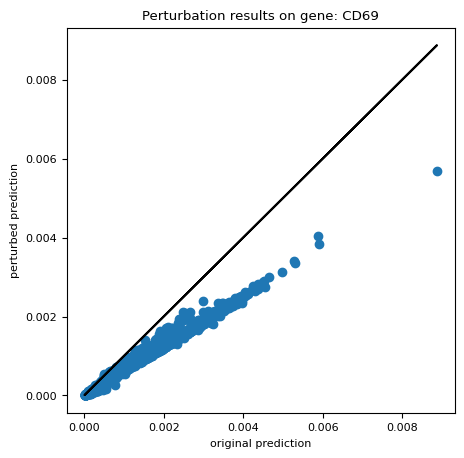

In [61]:
predicted_changes, samples_of_interest = model.gene2peak(gene_name=gene_name, testset=testset, plot=True)

### analyse

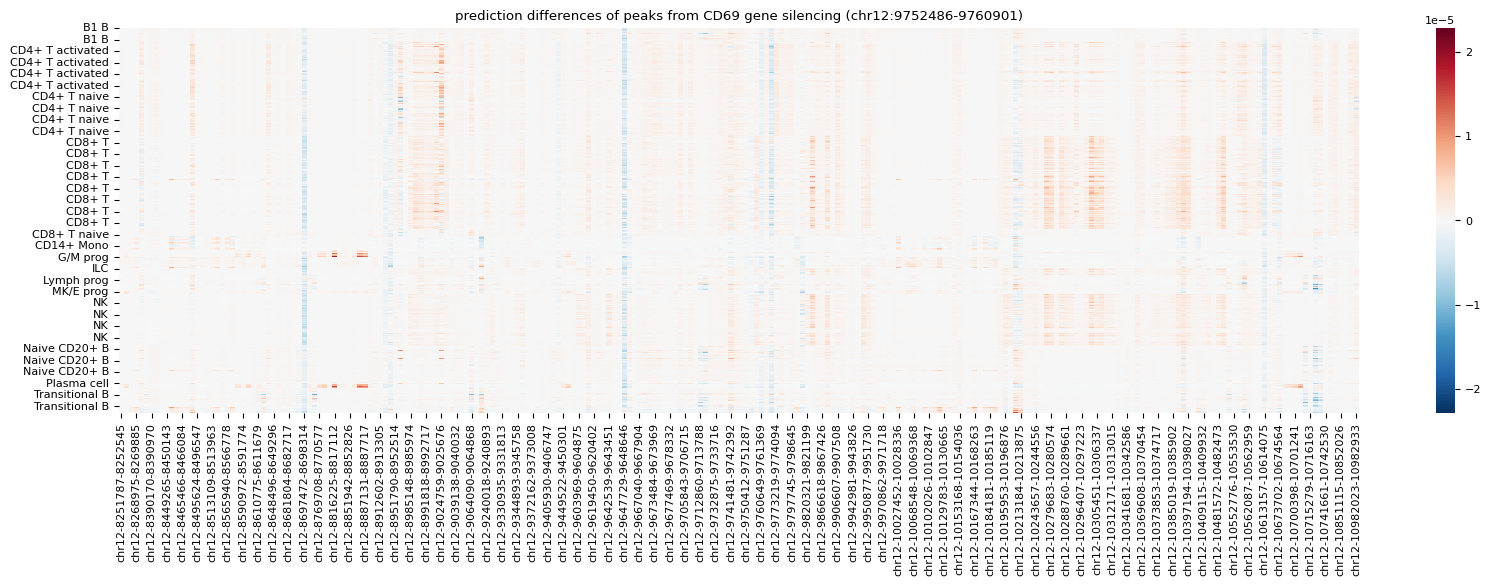

In [62]:
gene_chromosome = gene_location.split(":")[0]
window_start = int(gene_location.split(":")[1].split("-")[0]) - 1500000
window_end = int(gene_location.split(":")[1].split("-")[1]) + 1500000
# find the closest start and end peaks to the window start and end
start_peak, end_peak = find_closest_start_and_end(gene_chromosome, window_start, window_end)

cell_types = testset.obs['cell_type'].values[samples_of_interest]
heatmap_1 = predicted_changes[1][:,start_peak:end_peak]

df_heatmap_1 = plot_gel(heatmap_1, gene_name, gene_location)
cell_types_unique, cell_types_numbers = df_heatmap_1.index.value_counts().index.values, df_heatmap_1.index.value_counts().values

### as before

In [63]:
# plot the response in emma's window per cell type

window_size = 10000

df_hichip = prepare_df_emma(file_dir)
df_pos_intersect = np.sort(df_hichip['position'].unique())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = insilico_hichip(df_heatmap_1, [ct], bins=df_pos_intersect, window_size=window_size, norm=False, use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'multiDGD'
    })
    if i == 0:
        df_open_closed = df_open_closed_temp
    else:
        df_open_closed = pd.concat([df_open_closed, df_open_closed_temp], axis=0)

df_open_closed = pd.concat([df_open_closed, df_hichip], axis=0)
df_open_closed['position'] = df_open_closed['position'].values / 1e6
df_open_closed

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_1296/3221838582.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pos = df_pos.groupby(['position']).mean().reset_index()
/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_1296/3221838582.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['sample_name'] = 'negative'


position        signal           std cell type    method
0     9.457404  0.000000e+00  0.000000e+00    CD8+ T  multiDGD
1     9.467404  1.663740e-07  1.523306e-07    CD8+ T  multiDGD
2     9.477404  0.000000e+00  0.000000e+00    CD8+ T  multiDGD
3     9.557404  0.000000e+00  0.000000e+00    CD8+ T  multiDGD
4     9.577404  0.000000e+00  0.000000e+00    CD8+ T  multiDGD
..         ...           ...           ...       ...       ...
138   9.987401  1.458409e-01  0.000000e+00  negative    HiChIP
139   9.997401  1.458409e-01  0.000000e+00  negative    HiChIP
140  10.007401  8.750452e-01  0.000000e+00  negative    HiChIP
141  10.017401  2.916817e-01  0.000000e+00  negative    HiChIP
142  10.027401  5.833634e-01  0.000000e+00  negative    HiChIP

[1218 rows x 5 columns]

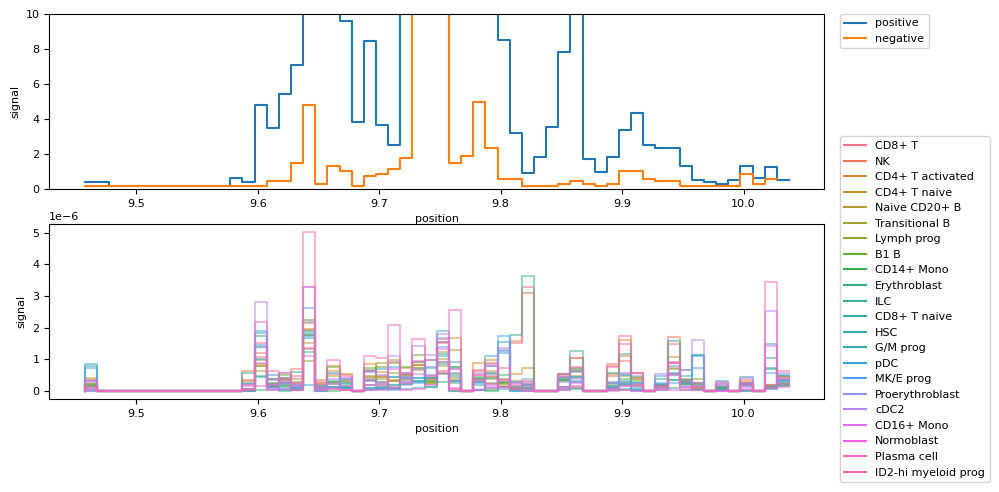

In [64]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
sns.lineplot(x='position', y='signal', data=df_open_closed[df_open_closed['method']=='HiChIP'], hue='cell type', ax=ax[0], drawstyle='steps-pre')
ax[0].set_ylim(0,10)
ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0.)
sns.lineplot(x='position', y='signal', data=df_open_closed[df_open_closed['method']=='multiDGD'], hue='cell type', ax=ax[1], alpha=0.5, drawstyle='steps-pre')
ax[1].legend(bbox_to_anchor=(1.02, 1.5), loc=2, borderaxespad=0.)
plt.show()

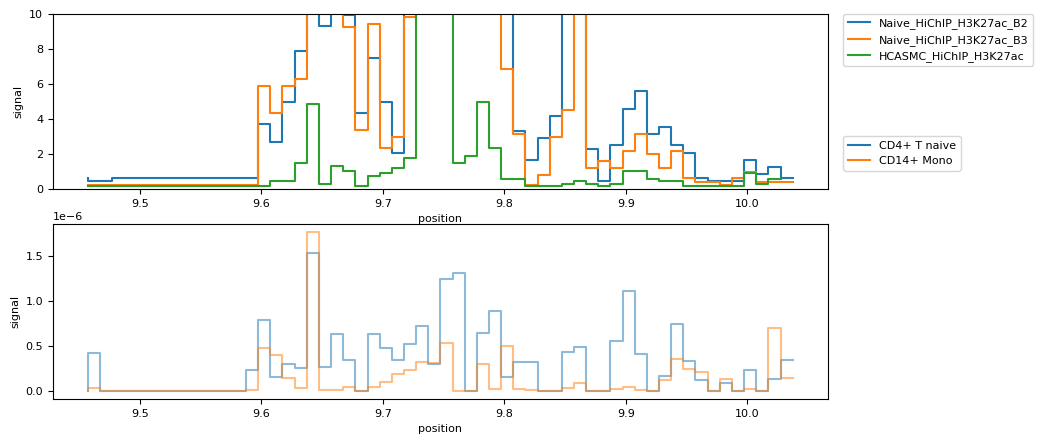

In [18]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
sns.lineplot(x='position', y='signal', data=df_open_closed[df_open_closed['method']=='HiChIP'], hue='cell type', ax=ax[0], drawstyle='steps-pre')
ax[0].set_ylim(0,10)
ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0.)
sns.lineplot(x='position', y='signal', data=df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type'].isin(['CD4+ T naive', 'CD14+ Mono']))], hue='cell type', ax=ax[1], alpha=0.5, drawstyle='steps-pre')
ax[1].legend(bbox_to_anchor=(1.02, 1.5), loc=2, borderaxespad=0.)
plt.show()

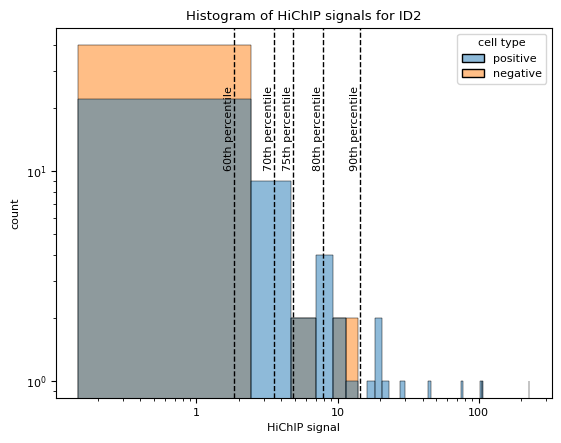

In [65]:
# plot histograms of the hichip values
from matplotlib.ticker import ScalarFormatter

sns.histplot(data=df_open_closed[df_open_closed['method']=='HiChIP'], x='signal', hue='cell type', bins=100, alpha=0.5)
# add lines for some percentiles
percentiles = [60, 70, 75, 80, 90]
for p in percentiles:
    plt.axvline(x=np.percentile(df_open_closed[df_open_closed['method']=='HiChIP']['signal'], p), color='black', linestyle='--', lw=1)
    plt.text(np.percentile(df_open_closed[df_open_closed['method']=='HiChIP']['signal'], p), 10, str(p)+'th percentile', rotation=90, va='bottom', ha='right')
plt.yscale('log')
plt.xscale('log')
# make the axis ticks normal numbers instead of scientific notation
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('HiChIP signal')
plt.ylabel('count')
plt.title('Histogram of HiChIP signals for ID2')
plt.show()

In [66]:
# get the 75th percentile of the hichip signals to have something to compare to for binarized data
df_open_closed_hichip = df_open_closed[df_open_closed['method']=='HiChIP'].copy()
thresh_hichip = df_open_closed_hichip['signal'].quantile(0.70)
print(thresh_hichip)

df_pos_intersect = np.sort(df_open_closed['position'].unique())

# now subset the data to these positions
#df_open_closed_hichip = df_open_closed_hichip[df_open_closed_hichip['position'].isin(df_pos_intersect)]

# now binarize the data
df_open_closed_binary_hichip = df_open_closed_hichip.copy()
df_open_closed_binary_hichip['signal'] = df_open_closed_binary_hichip['signal'].apply(lambda x: 1 if x > thresh_hichip else 0)
df_open_closed_binary_dgd = df_open_closed[df_open_closed['method']=='multiDGD'].copy()
# select the valid positions
#df_open_closed_binary_dgd = df_open_closed_binary_dgd[df_open_closed_binary_dgd['position'].isin(df_pos_intersect)]

3.519740930563173


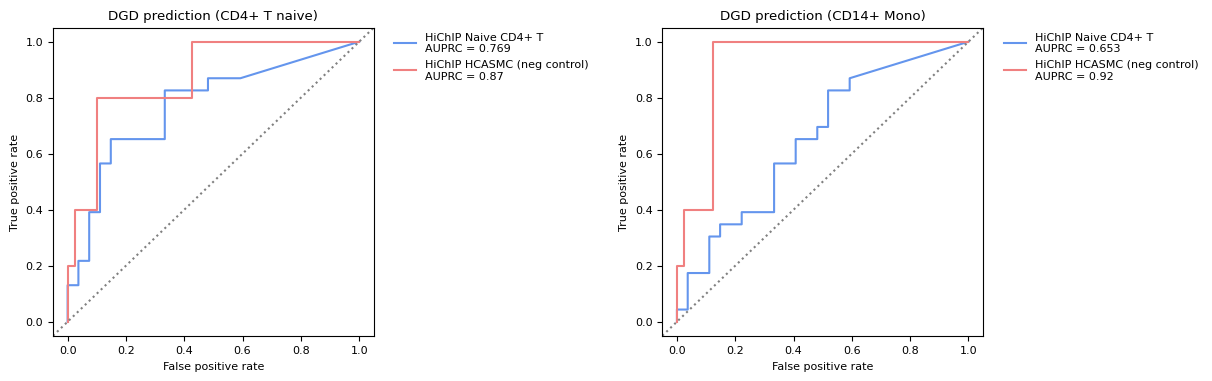

3.4396819614812557e-07

In [67]:
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'CD4+ T naive', 'CD14+ Mono')
optimal_threshold

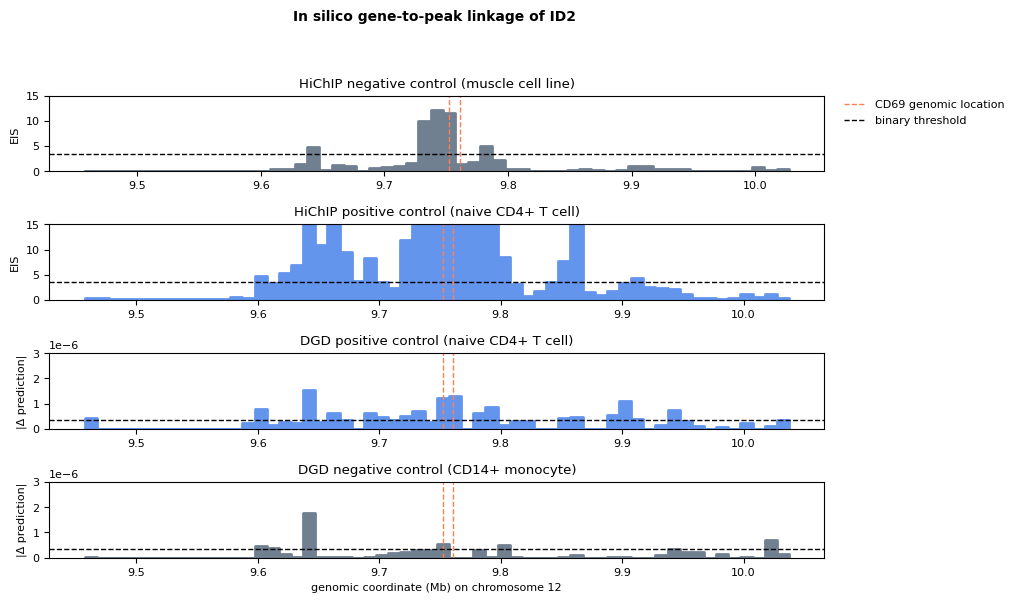

In [69]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions
gene_start = int(gene_location.split(":")[1].split("-")[0])/1e6
gene_end = int(gene_location.split(":")[1].split("-")[1])/1e6
thresh_dgd = optimal_threshold
thresholds = [thresh_hichip, thresh_hichip, thresh_dgd, thresh_dgd]
ylims = [15,15,3e-6,3e-6]
#ylims = [20,20,1e-5,1e-5]
ylabels = ['EIS','EIS','|Δ prediction|', '|Δ prediction|']
color_pos = 'cornflowerblue'
color_neg = 'slategray'
gene_color = 'coral'
gene_alpha = 1

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,6))
# adjust spacing
fig.subplots_adjust(hspace=0.7)

ax[0].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='negative')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='negative')]['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[0].set_title('HiChIP negative control (muscle cell line)')


ax[1].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='positive')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='positive')]['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[1].set_title('HiChIP positive control (naive CD4+ T cell)')

ax[2].fill_between(
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']=='CD4+ T naive')]['position'],
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']=='CD4+ T naive')]['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[2].set_title('DGD positive control (naive CD4+ T cell)')

ax[3].fill_between(
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']=='CD14+ Mono')]['position'],
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']=='CD14+ Mono')]['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[3].set_title('DGD negative control (CD14+ monocyte)')

for i in range(4):
    #ax[i].set_yscale('log')
    #ax[i].set_xlim(7.3,10.1)
    ax[i].axvline(x=gene_start, color=gene_color, linestyle='--', lw=1, label=gene_name+' genomic location')
    ax[i].axvline(x=gene_end, color=gene_color, linestyle='--', lw=1)
    ax[i].set_ylim(0,ylims[i])
    ax[i].axhline(y=thresholds[i], color='black', linestyle='--', lw=1, label='binary threshold')
    ax[i].set_ylabel(ylabels[i])
    if i < 3:
        ax[i].set_xlabel('')
    else:
        ax[3].set_xlabel('genomic coordinate (Mb) on chromosome '+gene_location.split(':')[0].split('chr')[1])

ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0., frameon=False)

caption = 'In silico gene-to-peak linkage of ID2'
fig.text(.51, 1.005, caption, ha='center', fontsize=10, fontweight='bold')

plt.show()

### with positive-negative

In [70]:
def prepare_df_emma(file_dir):
    df_emma = pd.read_csv(file_dir, sep=",")
    sample_names = df_emma.sample_name.unique()
    # average the positive controls
    df_pos = df_emma[df_emma.sample_name != 'HCASMC_HiChIP_H3K27ac']
    df_pos = df_pos.groupby(['position']).mean().reset_index()
    df_pos['sample_name'] = 'positive'
    df_pos = df_pos[['position', 'EIS', 'sample_name']]
    df_neg = df_emma[df_emma.sample_name == 'HCASMC_HiChIP_H3K27ac']
    df_neg['sample_name'] = 'negative'
    df_neg = df_neg[['position', 'EIS', 'sample_name']]
    df_emma_out = pd.concat([df_pos, df_neg])
    df_emma_out.columns = ['position', 'signal', 'cell type']
    df_emma_out['std'] = 0
    df_emma_out['method'] = 'HiChIP'
    return df_emma_out

# plot the response in emma's window per cell type

window_size = 10000

df_hichip = prepare_df_emma(file_dir)
df_pos_intersect = np.sort(df_hichip['position'].unique())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = insilico_hichip(df_heatmap_1, [ct], bins=df_pos_intersect, window_size=window_size, norm=False, use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'multiDGD'
    })
    if i == 0:
        df_open_closed = df_open_closed_temp
    else:
        df_open_closed = pd.concat([df_open_closed, df_open_closed_temp], axis=0)

df_open_closed = pd.concat([df_open_closed, df_hichip], axis=0)
df_open_closed['position'] = df_open_closed['position'].values / 1e6
print(df_hichip['cell type'].unique())

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_1296/3221838582.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pos = df_pos.groupby(['position']).mean().reset_index()
/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_1296/3221838582.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['sample_name'] = 'negative'


['positive' 'negative']


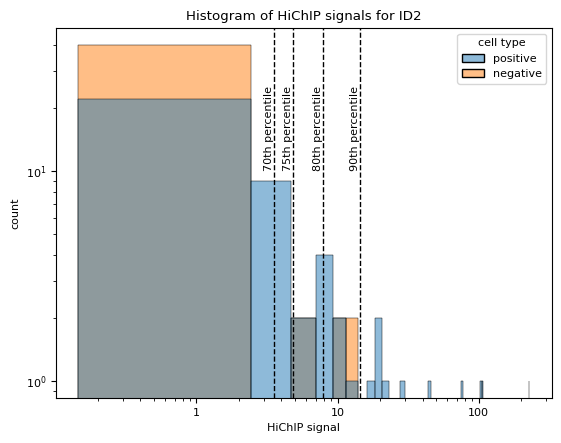

In [71]:
# plot histograms of the hichip values
from matplotlib.ticker import ScalarFormatter

sns.histplot(data=df_open_closed[df_open_closed['method']=='HiChIP'], x='signal', hue='cell type', bins=100, alpha=0.5)
# add lines for some percentiles
percentiles = [70, 75, 80, 90]
for p in percentiles:
    plt.axvline(x=np.percentile(df_open_closed[df_open_closed['method']=='HiChIP']['signal'], p), color='black', linestyle='--', lw=1)
    plt.text(np.percentile(df_open_closed[df_open_closed['method']=='HiChIP']['signal'], p), 10, str(p)+'th percentile', rotation=90, va='bottom', ha='right')
plt.yscale('log')
plt.xscale('log')
# make the axis ticks normal numbers instead of scientific notation
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('HiChIP signal')
plt.ylabel('count')
plt.title('Histogram of HiChIP signals for ID2')
plt.show()

In [72]:
# reindex the dataframe
df_open_closed.reset_index(inplace=True, drop=True)

# get the 75th percentile of the hichip signals to have something to compare to for binarized data
df_open_closed_hichip = df_open_closed[df_open_closed['method']=='HiChIP'].copy()
thresh_hichip = df_open_closed_hichip['signal'].quantile(0.85)
print(thresh_hichip)

df_pos_intersect = np.sort(df_open_closed['position'].unique())

# now subset the data to these positions
#df_open_closed_hichip = df_open_closed_hichip[df_open_closed_hichip['position'].isin(df_pos_intersect)]

# now binarize the data
df_open_closed_binary_hichip = df_open_closed_hichip.copy()
df_open_closed_binary_hichip['signal'] = df_open_closed_binary_hichip['signal'].apply(lambda x: 1 if x > thresh_hichip else 0)
df_open_closed_binary_dgd = df_open_closed[df_open_closed['method']=='multiDGD'].copy()
# select the valid positions
#df_open_closed_binary_dgd = df_open_closed_binary_dgd[df_open_closed_binary_dgd['position'].isin(df_pos_intersect)]

10.711597133008393


In [73]:
def plot_roc_curves(df_c, df_p, c_1, c_2, p_1, p_2, mode='prediction'):
    # now make ROC curves for the dgd predictions
    from sklearn.metrics import roc_curve, auc

    pos_color = 'cornflowerblue'
    neg_color = 'lightcoral'
    correction_color = 'slategray'

    # drop duplicates
    df_c = df_c.drop_duplicates()
    df_p = df_p.drop_duplicates()

    #print(df_c)
    #print(df_p)

    # create 2 subplots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    # adjust spacing
    fig.subplots_adjust(wspace=0.9)

    # first get the values for the same positions
    x, y = df_c[df_c['cell type']==c_1], df_p[df_p['cell type']==p_1]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    ax[0].plot(fpr, tpr, pos_color, label=f'HiChIP B cell lymphoblast\nAUPRC = {np.round(auprc, 3)}')

    x, y = df_c[df_c['cell type']==c_2], df_p[df_p['cell type']==p_1]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, neg_color, label=f'HiChIP HCASMC (neg control)\nAUPRC = {np.round(auprc, 3)}')
    ax[0].axline((min(fpr), min(tpr)), slope=1, color="grey", linestyle=':')
    ax[0].set_xlabel("False positive rate")
    ax[0].set_ylabel("True positive rate")
    if mode == 'prediction':
        ax[0].set_title("DGD prediction ({})".format(p_1))
    else:
        ax[0].set_title("Baseline correlation ({})".format(p_1))
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)


    x, y = df_c[df_c['cell type']==c_1], df_p[df_p['cell type']==p_2]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, pos_color, label=f'HiChIP B cell lymphoblast\nAUPRC = {np.round(auprc, 3)}')
    
    x, y = df_c[df_c['cell type']==c_2], df_p[df_p['cell type']==p_2]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, neg_color, label=f'HiChIP HCASMC (neg control)\nAUPRC = {np.round(auprc, 3)}')
    ax[1].axline((min(fpr), min(tpr)), slope=1, color="grey", linestyle=':')
    ax[1].set_xlabel("False positive rate")
    ax[1].set_ylabel("True positive rate")
    if mode == 'prediction':
        ax[1].set_title("DGD prediction ({})".format(p_2))
    else:
        ax[1].set_title("Baseline correlation ({})".format(p_2))
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)
    plt.show()

    return optimal_threshold

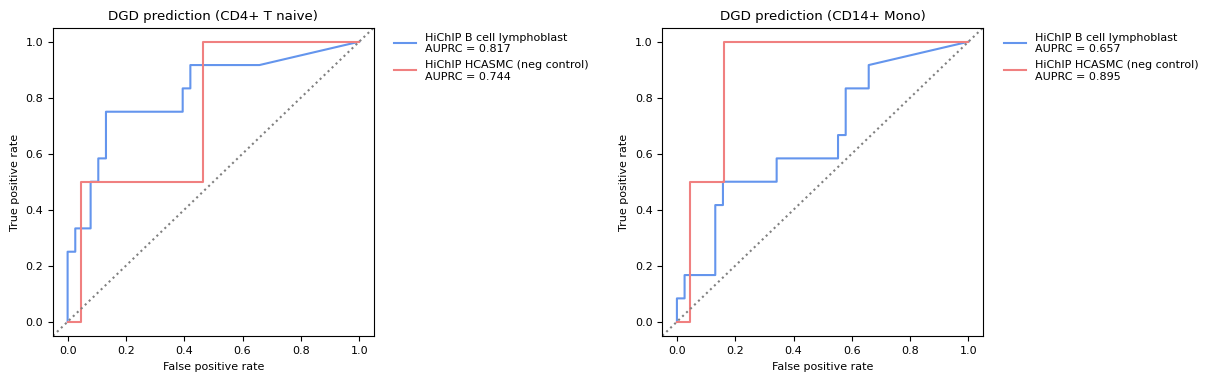

In [74]:
# threshold 0.85
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'CD4+ T naive', 'CD14+ Mono')

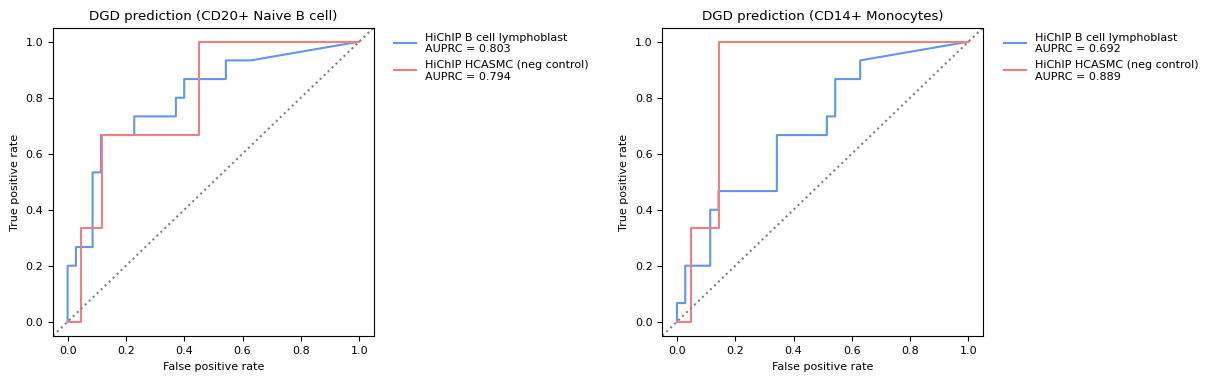

In [35]:
# threshold 0.8
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'CD4+ T naive', 'CD14+ Mono')

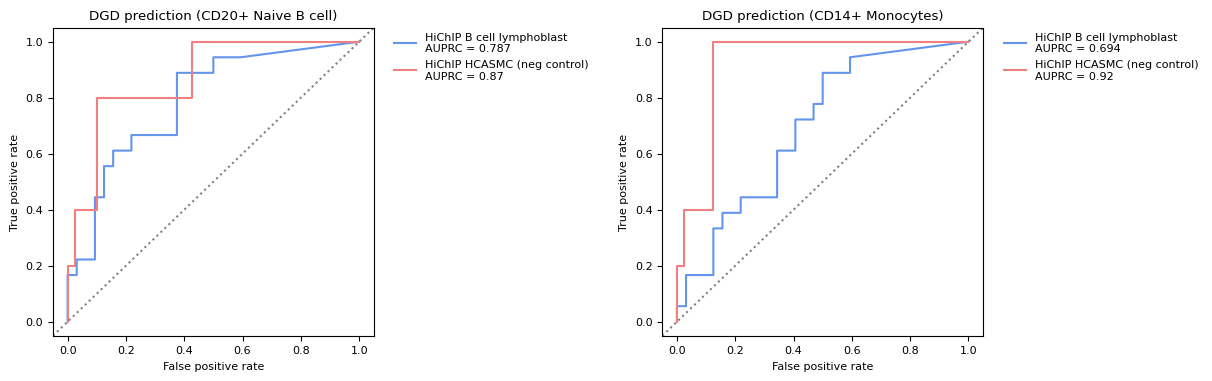

In [31]:
# threshold 0.75
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'CD4+ T naive', 'CD14+ Mono')

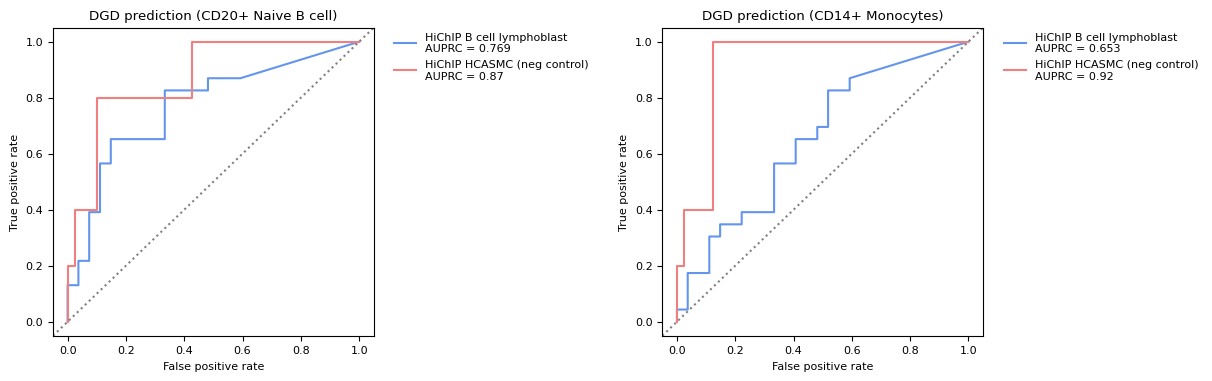

In [33]:
# threshold 0.7
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'CD4+ T naive', 'CD14+ Mono')

In [75]:
# save the dataframe
df_open_closed.to_csv('./results/analysis/analysis_referencedata/'+gene_name+'_hg38_hichip_dgd_aligned_locations.csv', index=False)

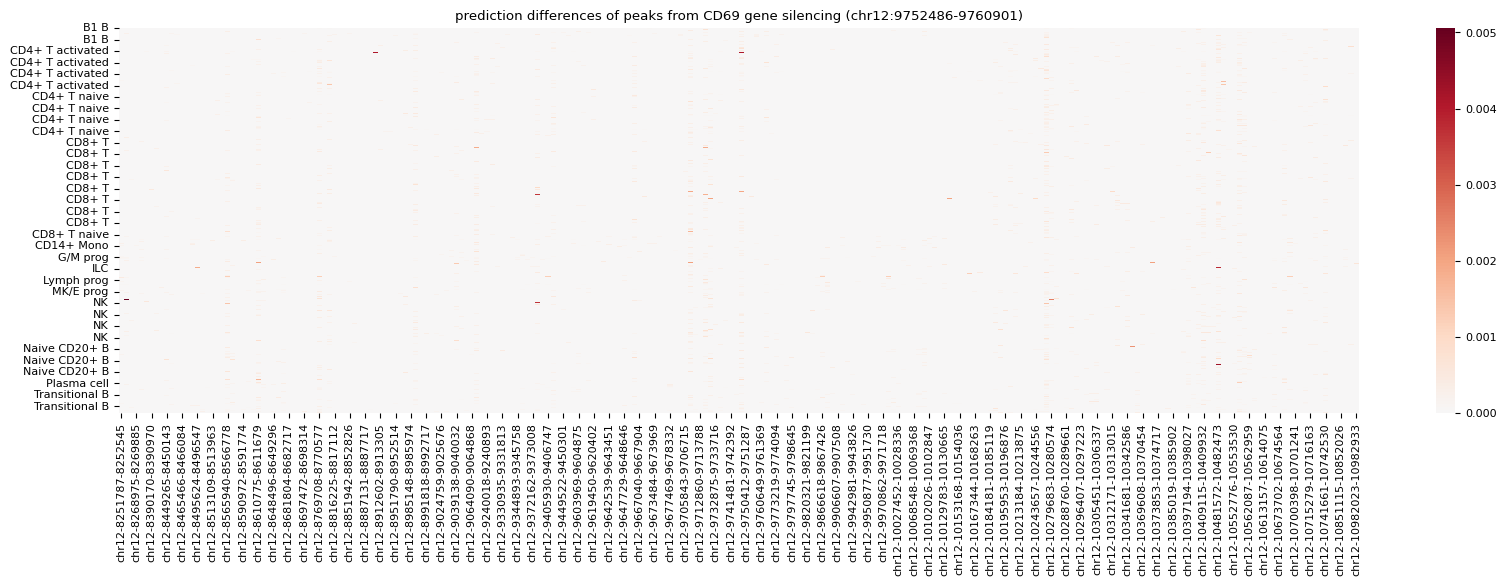

In [76]:
# now for normalized cell counts (divided by count depth of cell)

gex_count_depth = testset.obs['GEX_n_counts'].values[samples_of_interest]
atac_count_depth = testset.obs['ATAC_nCount_peaks'].values[samples_of_interest]

heatmap_control = torch.tensor(np.array(testset.X[samples_of_interest, start_peak:end_peak].todense())) / torch.tensor(atac_count_depth).unsqueeze(1)
df_heatmap_control = plot_gel(heatmap_control, gene_name, gene_location)

In [77]:
gene_counts = np.array(testset.X[samples_of_interest, gene_idx].todense())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = gene_correlation(
        gene_counts[np.where(testset[samples_of_interest].obs['cell_type'] == ct)[0]], 
        df_heatmap_control, 
        [ct], 
        bins=df_pos_intersect*1e6, 
        window_size=window_size, 
        norm=False, 
        use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'Spearman'
    })
    if i == 0:
        df_open_closed_control = df_open_closed_temp
    else:
        df_open_closed_control = pd.concat([df_open_closed_control, df_open_closed_temp], axis=0)

df_open_closed_control
df_open_closed_control.index = np.arange(len(df_open_closed_control))
df_open_closed_control['position'] = df_open_closed_control['position'] / 1e6

/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the

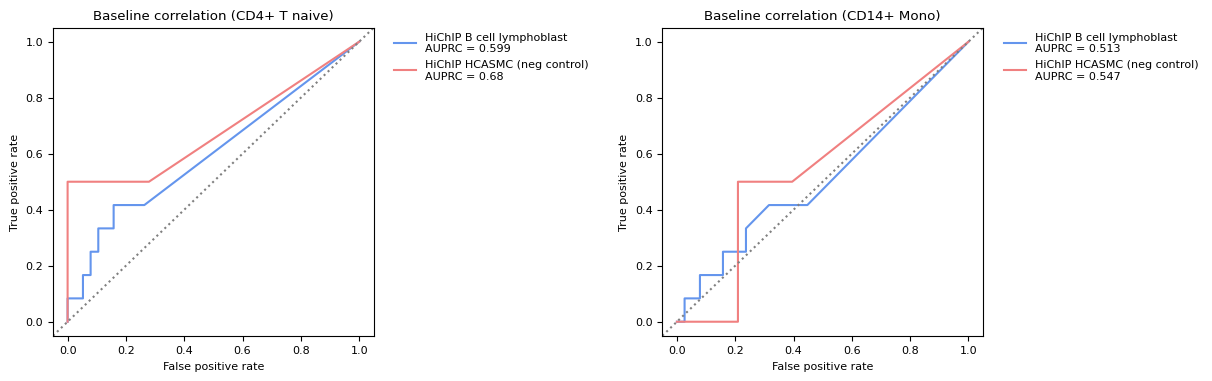

In [78]:
df_open_closed_control.fillna(0, inplace=True)

_ = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_control, 'positive', 'negative', 'CD4+ T naive', 'CD14+ Mono', mode='baseline')

In [79]:
# save the dataframe
df_open_closed_control.to_csv('./results/analysis/analysis_referencedata/'+gene_name+'_hg38_baseline_correlation.csv', index=False)

### baseline: correlation

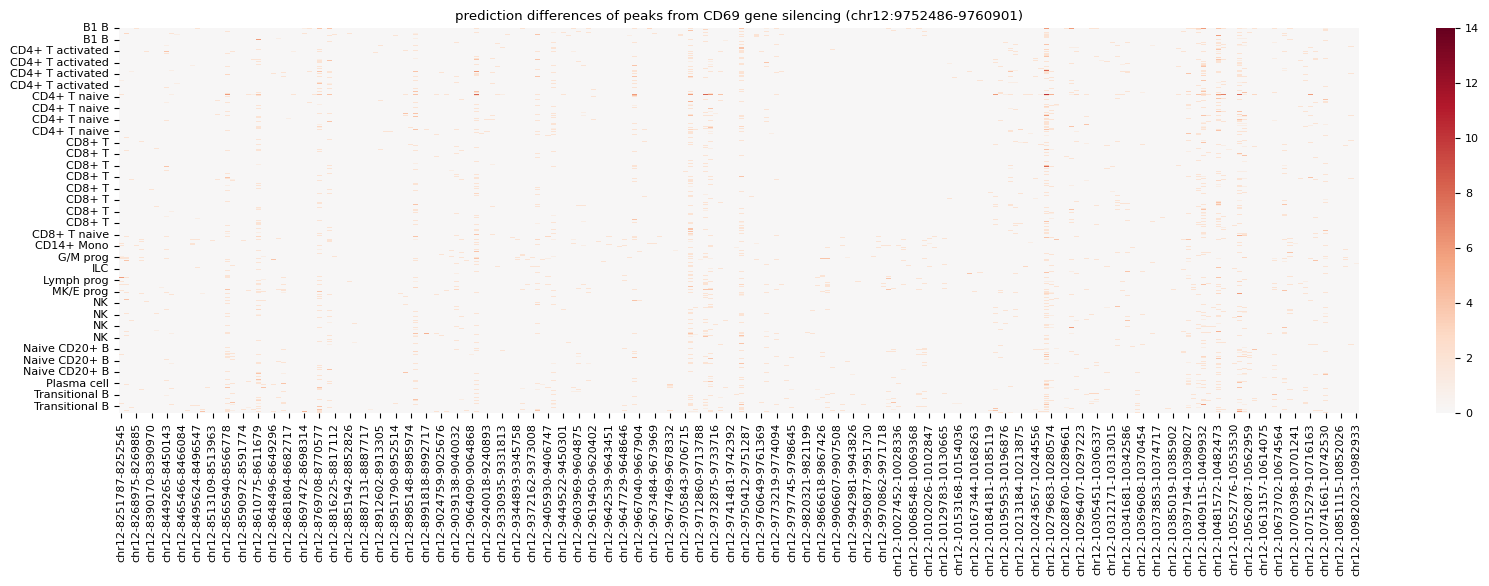

In [145]:
heatmap_control = torch.tensor(np.array(testset.X[samples_of_interest, start_peak:end_peak].todense()))
df_heatmap_control = plot_gel(heatmap_control, gene_name, gene_location)

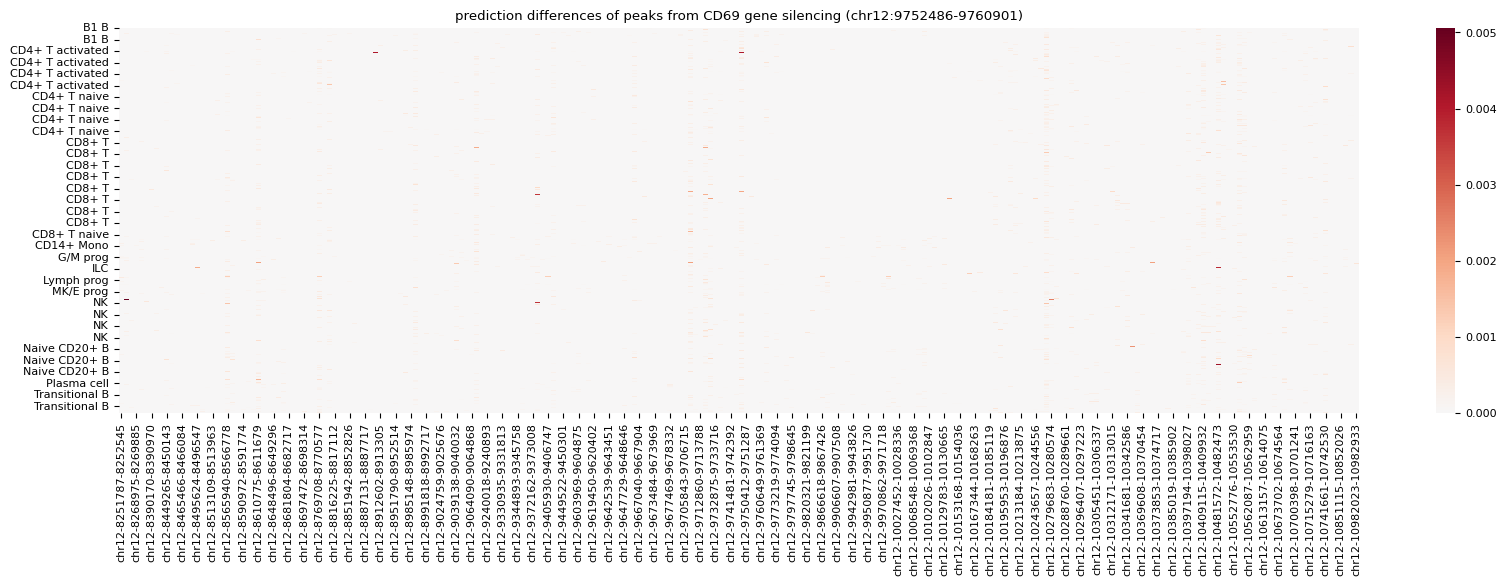

In [220]:
# now for normalized cell counts (divided by count depth of cell)

gex_count_depth = testset.obs['GEX_n_counts'].values[samples_of_interest]
atac_count_depth = testset.obs['ATAC_nCount_peaks'].values[samples_of_interest]

heatmap_control = torch.tensor(np.array(testset.X[samples_of_interest, start_peak:end_peak].todense())) / torch.tensor(atac_count_depth).unsqueeze(1)
df_heatmap_control = plot_gel(heatmap_control, gene_name, gene_location)

In [221]:
gene_counts = np.array(testset.X[samples_of_interest, gene_idx].todense())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = gene_correlation(
        gene_counts[np.where(testset[samples_of_interest].obs['cell_type'] == ct)[0]], 
        df_heatmap_control, 
        [ct], 
        bins=df_pos_intersect*1e6, 
        window_size=window_size, 
        norm=False, 
        use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'Spearman'
    })
    if i == 0:
        df_open_closed_control = df_open_closed_temp
    else:
        df_open_closed_control = pd.concat([df_open_closed_control, df_open_closed_temp], axis=0)

df_open_closed_control
df_open_closed_control.index = np.arange(len(df_open_closed_control))
df_open_closed_control['position'] = df_open_closed_control['position'] / 1e6

/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the

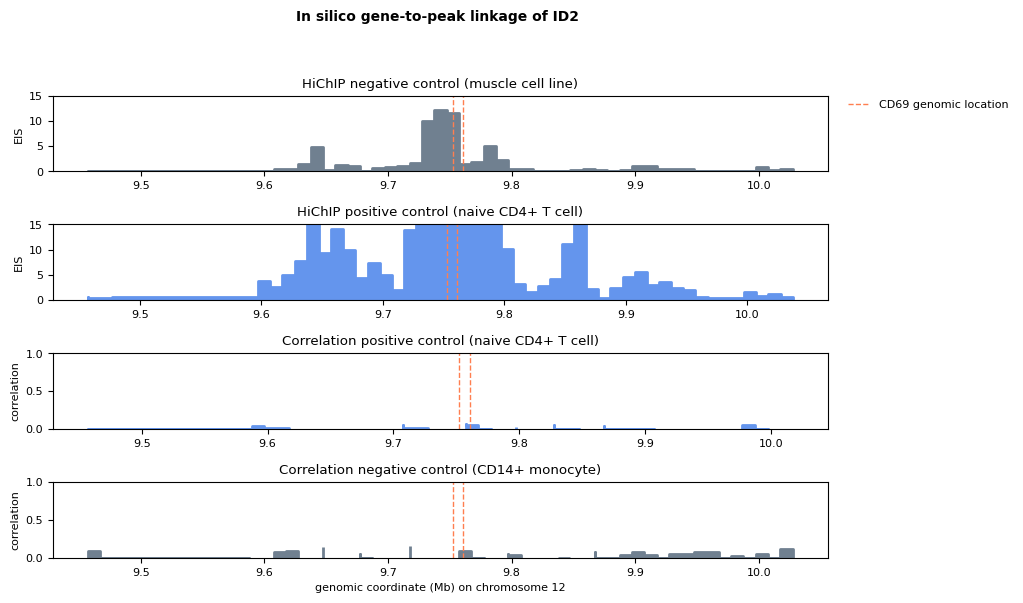

In [148]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions
ylims = [15,15,1,1]
ylabels = ['EIS','EIS','correlation', 'correlation']
color_pos = 'cornflowerblue'
color_neg = 'slategray'
gene_color = 'coral'
gene_alpha = 1

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,6))
# adjust spacing
fig.subplots_adjust(hspace=0.7)

ax[0].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='HCASMC_HiChIP_H3K27ac')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='HCASMC_HiChIP_H3K27ac')]['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[0].set_title('HiChIP negative control (muscle cell line)')


ax[1].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='Naive_HiChIP_H3K27ac_B2')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='Naive_HiChIP_H3K27ac_B2')]['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[1].set_title('HiChIP positive control (naive CD4+ T cell)')

ax[2].fill_between(
    df_open_closed_control[df_open_closed_control['cell type']=='CD4+ T naive']['position'],
    df_open_closed_control[df_open_closed_control['cell type']=='CD4+ T naive']['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[2].set_title('Correlation positive control (naive CD4+ T cell)')

ax[3].fill_between(
    df_open_closed_control[df_open_closed_control['cell type']=='CD14+ Mono']['position'],
    df_open_closed_control[df_open_closed_control['cell type']=='CD14+ Mono']['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[3].set_title('Correlation negative control (CD14+ monocyte)')

for i in range(4):
    #ax[i].set_yscale('log')
    #ax[i].set_xlim(7.3,10.1)
    ax[i].axvline(x=gene_start, color=gene_color, linestyle='--', lw=1, label=gene_name+' genomic location')
    ax[i].axvline(x=gene_end, color=gene_color, linestyle='--', lw=1)
    ax[i].set_ylim(0,ylims[i])
    #ax[i].axhline(y=thresholds[i], color='black', linestyle='--', lw=1, label='binary threshold')
    ax[i].set_ylabel(ylabels[i])
    if i < 3:
        ax[i].set_xlabel('')
    else:
        ax[3].set_xlabel('genomic coordinate (Mb) on chromosome '+gene_location.split(':')[0].split('chr')[1])

ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0., frameon=False)

caption = 'In silico gene-to-peak linkage of ID2'
fig.text(.51, 1.005, caption, ha='center', fontsize=10, fontweight='bold')

plt.show()

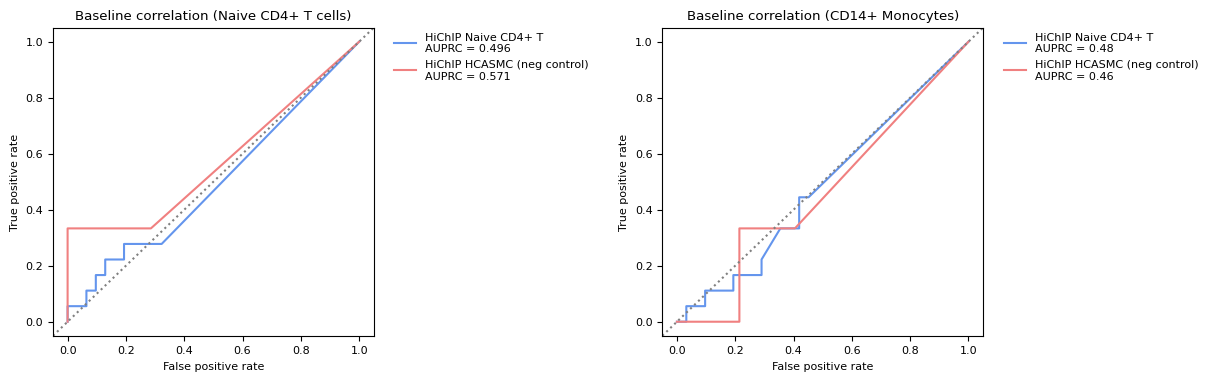

In [222]:
df_open_closed_control.fillna(0, inplace=True)

_ = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_control, 'Naive_HiChIP_H3K27ac_B2', 'HCASMC_HiChIP_H3K27ac', 'CD4+ T naive', 'CD14+ Mono', mode='baseline')

## New gene: CLEC16A

In [28]:
gene_name = "CLEC16A"
gene_location = "chr16:10944539-11182186"

file_dir = "./results/analysis/analysis_referencedata/EIS_signal_"+gene_name+"promoter.hg38.csv"
gene_id, gene_idx = get_gene_ids(gene_name)
peak_ids = find_closest_peak(gene_location)
print("Gene ID is {} at index {}, peak positions are {}".format(gene_id, gene_idx, peak_ids))

Gene ID is ENSG00000038532 at index 9811, peak positions are [39911, 39912, 39913, 39914, 39915, 39916, 39917, 39918, 39919, 39920, 39921, 39922, 39923, 39924, 39925, 39926, 39927, 39928, 39929, 39930, 39931, 39932, 39933, 39934]


In [29]:
#print the gene locations of the two closest peak_ids
print("The two closest peaks are located at:")
for peak_id in peak_ids:
    print(peak_id, testset.var.index[peak_id + modality_switch])

The two closest peaks are located at:
39911 chr16-10944074-10944961
39912 chr16-10949108-10950020
39913 chr16-10953661-10954575
39914 chr16-10957700-10958535
39915 chr16-10963807-10964661
39916 chr16-10965751-10966679
39917 chr16-10971345-10971918
39918 chr16-10972033-10972717
39919 chr16-10981505-10982411
39920 chr16-10987226-10988043
39921 chr16-10988340-10989140
39922 chr16-11052152-11053023
39923 chr16-11066180-11066949
39924 chr16-11076040-11076935
39925 chr16-11077716-11078615
39926 chr16-11087881-11088802
39927 chr16-11093909-11094786
39928 chr16-11104837-11105688
39929 chr16-11112648-11113500
39930 chr16-11114461-11115378
39931 chr16-11128453-11129256
39932 chr16-11135156-11136045
39933 chr16-11152774-11153602
39934 chr16-11181618-11182514


there are a lot of peaks containing part of this gene

using 1371 samples


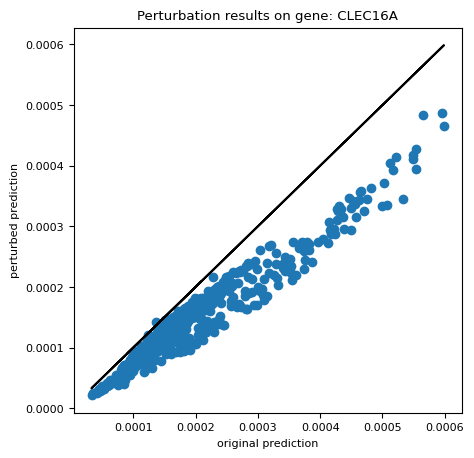

In [30]:
predicted_changes, samples_of_interest = model.gene2peak(gene_name=gene_name, testset=testset, plot=True)

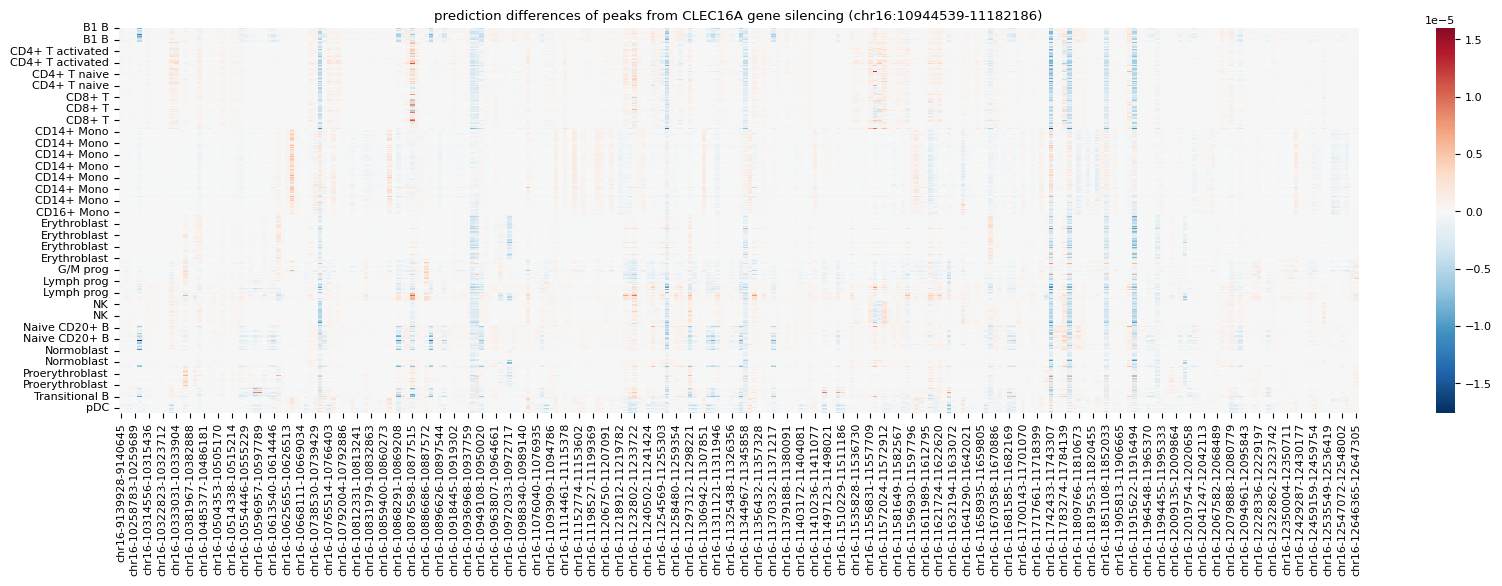

In [31]:
gene_chromosome = gene_location.split(":")[0]
window_start = int(gene_location.split(":")[1].split("-")[0]) - 1500000
window_end = int(gene_location.split(":")[1].split("-")[1]) + 1500000
# find the closest start and end peaks to the window start and end
start_peak, end_peak = find_closest_start_and_end(gene_chromosome, window_start, window_end)

cell_types = testset.obs['cell_type'].values[samples_of_interest]
heatmap_1 = predicted_changes[1][:,start_peak:end_peak]

df_heatmap_1 = plot_gel(heatmap_1, gene_name, gene_location)
cell_types_unique, cell_types_numbers = df_heatmap_1.index.value_counts().index.values, df_heatmap_1.index.value_counts().values

In [42]:
# plot the response in emma's window per cell type

window_size = 10000

df_hichip = prepare_df_emma(file_dir)
df_pos_intersect = np.sort(df_hichip['position'].unique())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = insilico_hichip(df_heatmap_1, [ct], bins=df_pos_intersect, window_size=window_size, norm=False, use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'multiDGD'
    })
    if i == 0:
        df_open_closed = df_open_closed_temp
    else:
        df_open_closed = pd.concat([df_open_closed, df_open_closed_temp], axis=0)

df_open_closed = pd.concat([df_open_closed, df_hichip], axis=0)
df_open_closed['position'] = df_open_closed['position'].values / 1e6
df_open_closed

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_1296/3221838582.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pos = df_pos.groupby(['position']).mean().reset_index()
/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_1296/3221838582.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['sample_name'] = 'negative'


position    signal  std   cell type    method
0    10.196143  0.000000  0.0  CD14+ Mono  multiDGD
1    10.206143  0.000000  0.0  CD14+ Mono  multiDGD
2    10.216143  0.000000  0.0  CD14+ Mono  multiDGD
3    10.226143  0.000000  0.0  CD14+ Mono  multiDGD
4    10.236143  0.000000  0.0  CD14+ Mono  multiDGD
..         ...       ...  ...         ...       ...
384  11.636144  3.211834  0.0    negative    HiChIP
385  11.646144  0.802958  0.0    negative    HiChIP
386  11.656144  1.204438  0.0    negative    HiChIP
387  11.666144  1.405177  0.0    negative    HiChIP
388  11.676144  0.602219  0.0    negative    HiChIP

[3559 rows x 5 columns]

In [47]:
# save the dataframe
df_open_closed.to_csv('./results/analysis/analysis_referencedata/'+gene_name+'_hg38_hichip_dgd_aligned_locations.csv', index=False)

In [43]:
df_hichip['cell type'].unique()

array(['positive', 'negative'], dtype=object)

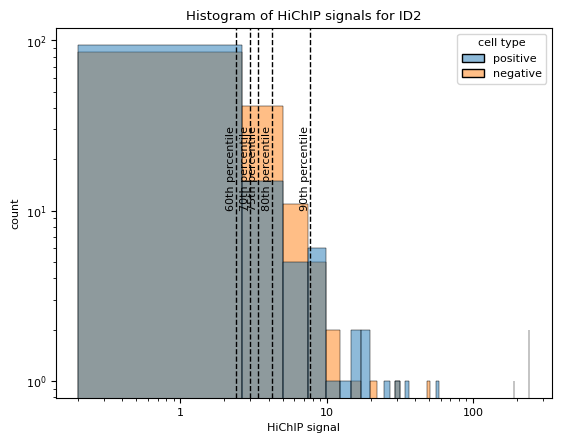

In [44]:
# plot histograms of the hichip values
from matplotlib.ticker import ScalarFormatter

sns.histplot(data=df_open_closed[df_open_closed['method']=='HiChIP'], x='signal', hue='cell type', bins=100, alpha=0.5)
# add lines for some percentiles
percentiles = [60, 70, 75, 80, 90]
for p in percentiles:
    plt.axvline(x=np.percentile(df_open_closed[df_open_closed['method']=='HiChIP']['signal'], p), color='black', linestyle='--', lw=1)
    plt.text(np.percentile(df_open_closed[df_open_closed['method']=='HiChIP']['signal'], p), 10, str(p)+'th percentile', rotation=90, va='bottom', ha='right')
plt.yscale('log')
plt.xscale('log')
# make the axis ticks normal numbers instead of scientific notation
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('HiChIP signal')
plt.ylabel('count')
plt.title('Histogram of HiChIP signals for ID2')
plt.show()

In [45]:
# get the 75th percentile of the hichip signals to have something to compare to for binarized data
df_open_closed_hichip = df_open_closed[df_open_closed['method']=='HiChIP'].copy()
thresh_hichip = df_open_closed_hichip['signal'].quantile(0.70)
print(thresh_hichip)

df_pos_intersect = np.sort(df_open_closed['position'].unique())

# now subset the data to these positions
#df_open_closed_hichip = df_open_closed_hichip[df_open_closed_hichip['position'].isin(df_pos_intersect)]

# now binarize the data
df_open_closed_binary_hichip = df_open_closed_hichip.copy()
df_open_closed_binary_hichip['signal'] = df_open_closed_binary_hichip['signal'].apply(lambda x: 1 if x > thresh_hichip else 0)
df_open_closed_binary_dgd = df_open_closed[df_open_closed['method']=='multiDGD'].copy()
# select the valid positions
#df_open_closed_binary_dgd = df_open_closed_binary_dgd[df_open_closed_binary_dgd['position'].isin(df_pos_intersect)]

3.01109407500997


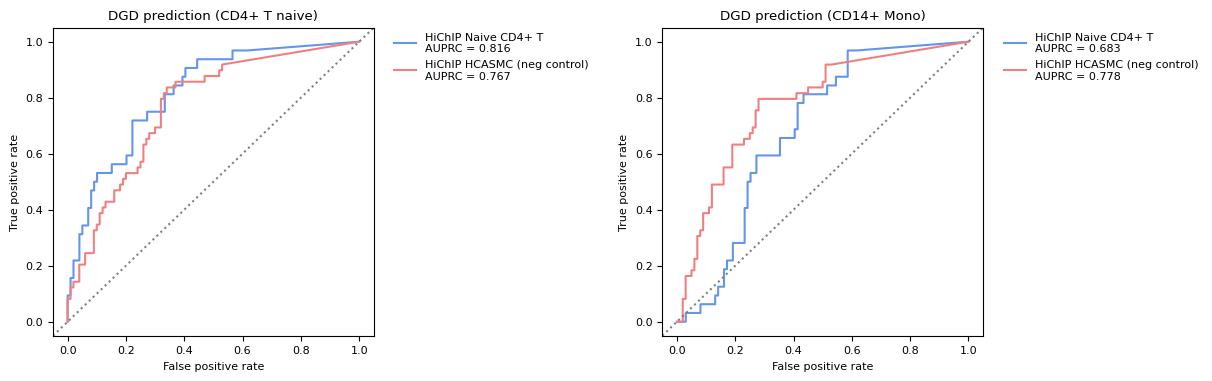

4.644353523985956e-08

In [46]:
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'CD4+ T naive', 'CD14+ Mono')
optimal_threshold

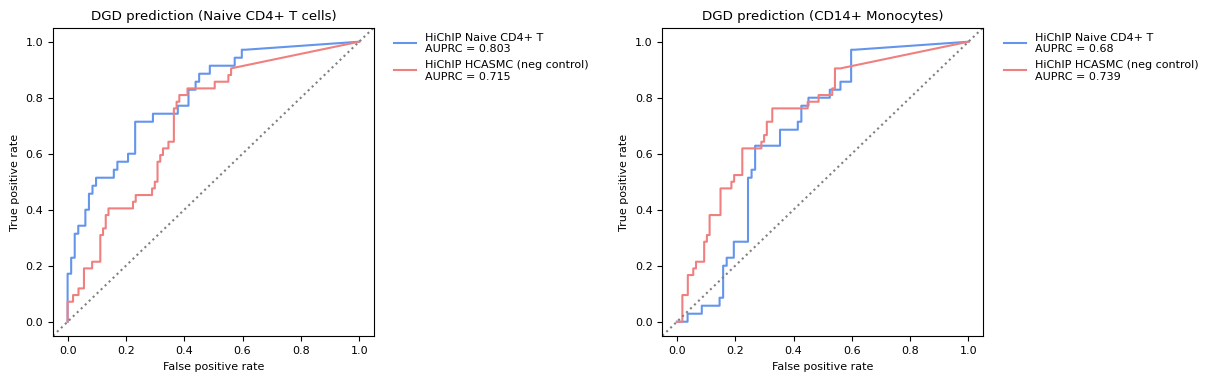

In [120]:
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'Naive_HiChIP_H3K27ac_B2', 'HCASMC_HiChIP_H3K27ac', 'CD4+ T naive', 'CD14+ Mono')

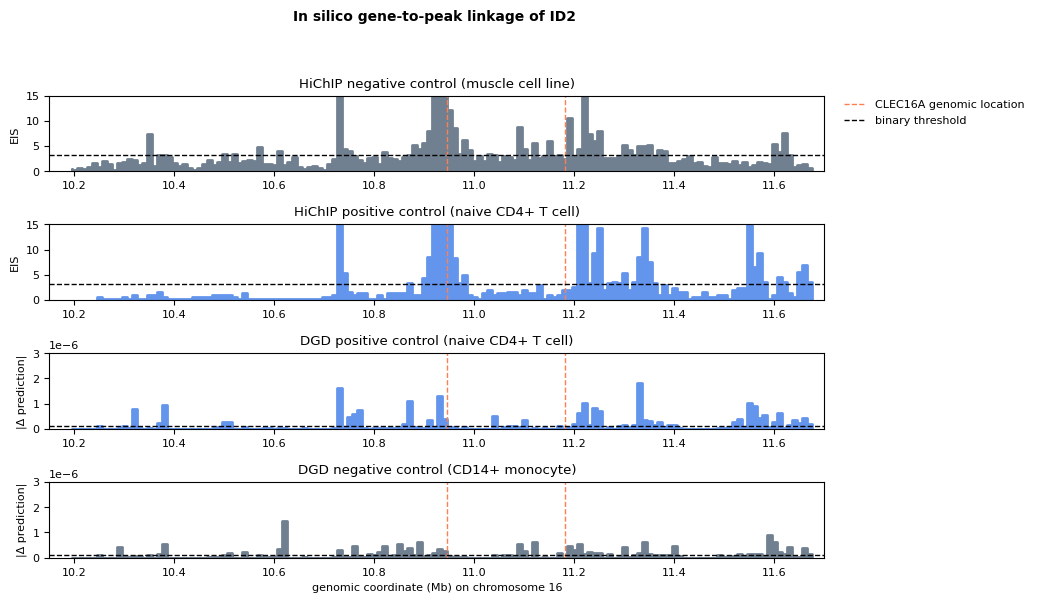

In [121]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions
gene_start = int(gene_location.split(":")[1].split("-")[0])/1e6
gene_end = int(gene_location.split(":")[1].split("-")[1])/1e6
thresh_dgd = optimal_threshold
thresholds = [thresh_hichip, thresh_hichip, thresh_dgd, thresh_dgd]
ylims = [15,15,3e-6,3e-6]
#ylims = [20,20,1e-5,1e-5]
ylabels = ['EIS','EIS','|Δ prediction|', '|Δ prediction|']
color_pos = 'cornflowerblue'
color_neg = 'slategray'
gene_color = 'coral'
gene_alpha = 1

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,6))
# adjust spacing
fig.subplots_adjust(hspace=0.7)

ax[0].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='HCASMC_HiChIP_H3K27ac')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='HCASMC_HiChIP_H3K27ac')]['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[0].set_title('HiChIP negative control (muscle cell line)')


ax[1].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='Naive_HiChIP_H3K27ac_B2')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='Naive_HiChIP_H3K27ac_B2')]['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[1].set_title('HiChIP positive control (naive CD4+ T cell)')

ax[2].fill_between(
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']=='CD4+ T naive')]['position'],
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']=='CD4+ T naive')]['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[2].set_title('DGD positive control (naive CD4+ T cell)')

ax[3].fill_between(
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']=='CD14+ Mono')]['position'],
    df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type']=='CD14+ Mono')]['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[3].set_title('DGD negative control (CD14+ monocyte)')

for i in range(4):
    #ax[i].set_yscale('log')
    ax[i].set_xlim(10.15,11.7)
    ax[i].axvline(x=gene_start, color=gene_color, linestyle='--', lw=1, label=gene_name+' genomic location')
    ax[i].axvline(x=gene_end, color=gene_color, linestyle='--', lw=1)
    ax[i].set_ylim(0,ylims[i])
    ax[i].axhline(y=thresholds[i], color='black', linestyle='--', lw=1, label='binary threshold')
    ax[i].set_ylabel(ylabels[i])
    if i < 3:
        ax[i].set_xlabel('')
    else:
        ax[3].set_xlabel('genomic coordinate (Mb) on chromosome '+gene_location.split(":")[0].split("chr")[1])

ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0., frameon=False)
#
#caption = 'In silico gene-to-peak linkage of ID2'
fig.text(.51, 1.005, caption, ha='center', fontsize=10, fontweight='bold')

plt.show()

#### baseline correlation

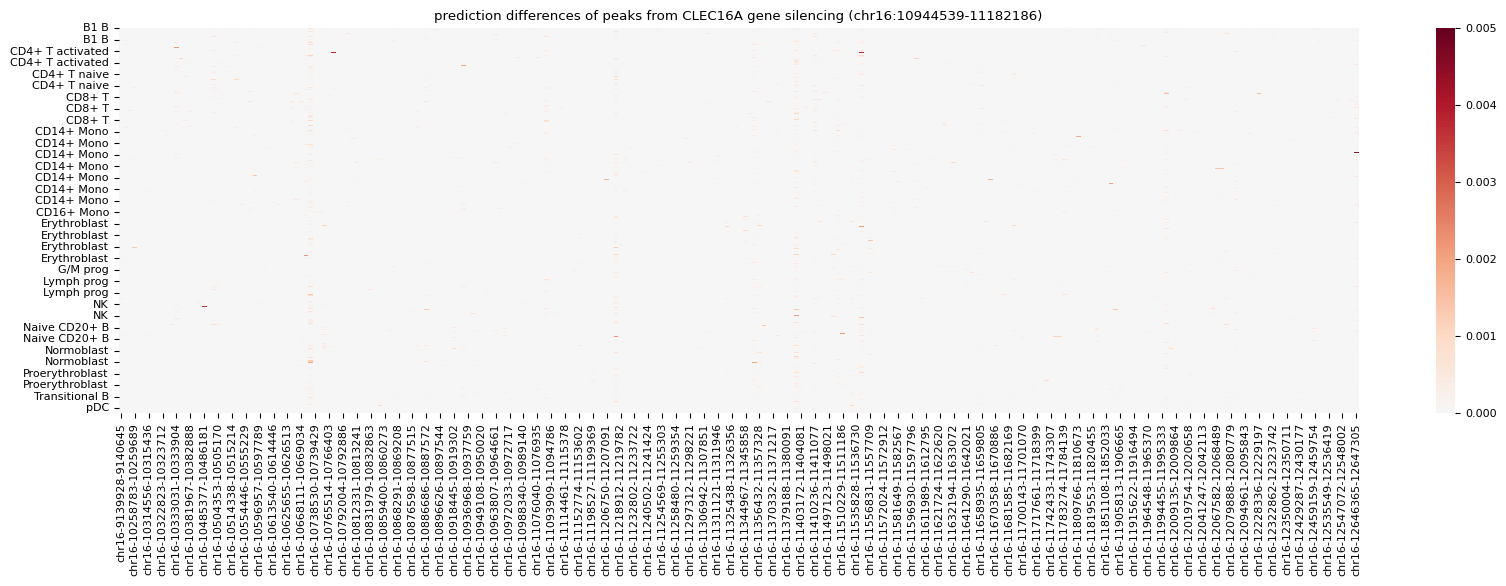

In [48]:
# now for normalized cell counts (divided by count depth of cell)

gex_count_depth = testset.obs['GEX_n_counts'].values[samples_of_interest]
atac_count_depth = testset.obs['ATAC_nCount_peaks'].values[samples_of_interest]

heatmap_control = torch.tensor(np.array(testset.X[samples_of_interest, start_peak:end_peak].todense())) / torch.tensor(atac_count_depth).unsqueeze(1)
df_heatmap_control = plot_gel(heatmap_control, gene_name, gene_location)

In [49]:
gene_counts = np.array(testset.X[samples_of_interest, gene_idx].todense())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = gene_correlation(
        gene_counts[np.where(testset[samples_of_interest].obs['cell_type'] == ct)[0]], 
        df_heatmap_control, 
        [ct], 
        bins=df_pos_intersect*1e6, 
        window_size=window_size, 
        norm=False, 
        use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'Spearman'
    })
    if i == 0:
        df_open_closed_control = df_open_closed_temp
    else:
        df_open_closed_control = pd.concat([df_open_closed_control, df_open_closed_temp], axis=0)

df_open_closed_control
df_open_closed_control.index = np.arange(len(df_open_closed_control))
df_open_closed_control['position'] = df_open_closed_control['position'] / 1e6

/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the

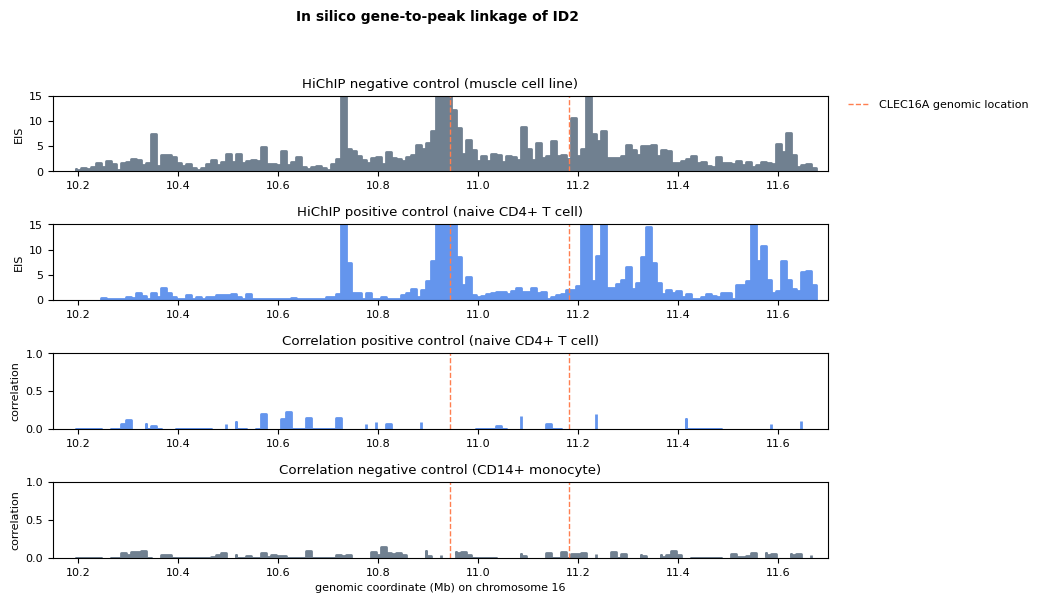

In [53]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions
ylims = [15,15,1,1]
ylabels = ['EIS','EIS','correlation', 'correlation']
color_pos = 'cornflowerblue'
color_neg = 'slategray'
gene_color = 'coral'
gene_alpha = 1

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,6))
# adjust spacing
fig.subplots_adjust(hspace=0.7)

ax[0].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='negative')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='negative')]['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[0].set_title('HiChIP negative control (muscle cell line)')


ax[1].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='positive')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='positive')]['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[1].set_title('HiChIP positive control (naive CD4+ T cell)')

ax[2].fill_between(
    df_open_closed_control[df_open_closed_control['cell type']=='CD4+ T naive']['position'],
    df_open_closed_control[df_open_closed_control['cell type']=='CD4+ T naive']['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[2].set_title('Correlation positive control (naive CD4+ T cell)')

ax[3].fill_between(
    df_open_closed_control[df_open_closed_control['cell type']=='CD14+ Mono']['position'],
    df_open_closed_control[df_open_closed_control['cell type']=='CD14+ Mono']['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[3].set_title('Correlation negative control (CD14+ monocyte)')

for i in range(4):
    #ax[i].set_yscale('log')
    ax[i].set_xlim(10.15,11.7)
    ax[i].axvline(x=gene_start, color=gene_color, linestyle='--', lw=1, label=gene_name+' genomic location')
    ax[i].axvline(x=gene_end, color=gene_color, linestyle='--', lw=1)
    ax[i].set_ylim(0,ylims[i])
    #ax[i].axhline(y=thresholds[i], color='black', linestyle='--', lw=1, label='binary threshold')
    ax[i].set_ylabel(ylabels[i])
    if i < 3:
        ax[i].set_xlabel('')
    else:
        ax[3].set_xlabel('genomic coordinate (Mb) on chromosome '+gene_location.split(':')[0].split('chr')[1])

ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0., frameon=False)

caption = 'In silico gene-to-peak linkage of ID2'
fig.text(.51, 1.005, caption, ha='center', fontsize=10, fontweight='bold')

plt.show()

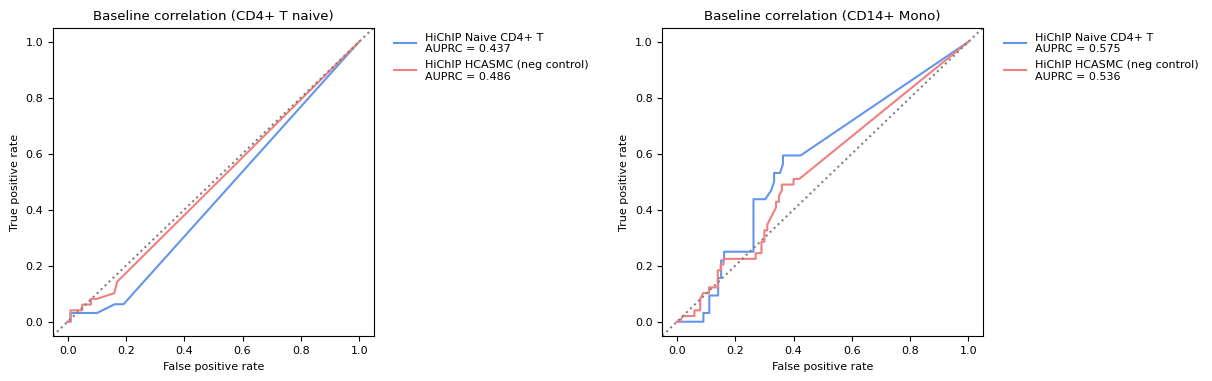

In [54]:
df_open_closed_control.fillna(0, inplace=True)

_ = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_control, 'positive', 'negative', 'CD4+ T naive', 'CD14+ Mono', mode='baseline')

In [55]:
# save the dataframe
df_open_closed_control.to_csv('./results/analysis/analysis_referencedata/'+gene_name+'_hg38_baseline_correlation.csv', index=False)

## New gene: CD19

In [56]:
gene_name = "CD19"
gene_location = "chr16:28931965-28939342"

file_dir = "./results/analysis/analysis_referencedata/EIS_signal_"+gene_name+"promoter.hg38.csv"
gene_id, gene_idx = get_gene_ids(gene_name)
peak_ids = find_closest_peak(gene_location)
print("Gene ID is {} at index {}, peak positions are {}".format(gene_id, gene_idx, peak_ids))

Gene ID is ENSG00000177455 at index 9925, peak positions are [40808]


(0.0, 50.0)

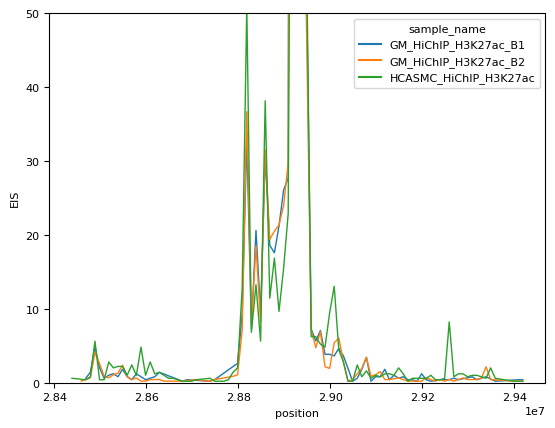

In [57]:
gene_name = "CD19"
df_emma = pd.read_csv("./results/analysis/analysis_referencedata/EIS_signal_"+gene_name+"promoter.hg38.csv")
sns.lineplot(data=df_emma, x='position', y='EIS', hue='sample_name', lw=1)
plt.ylim(0,50)

In [27]:
#print the gene locations of the two closest peak_ids
print("The two closest peaks are located at:")
for peak_id in peak_ids:
    print(peak_id, testset.var.index[peak_id + modality_switch])

The two closest peaks are located at:
40808 chr16-28936224-28937125


using 98 samples


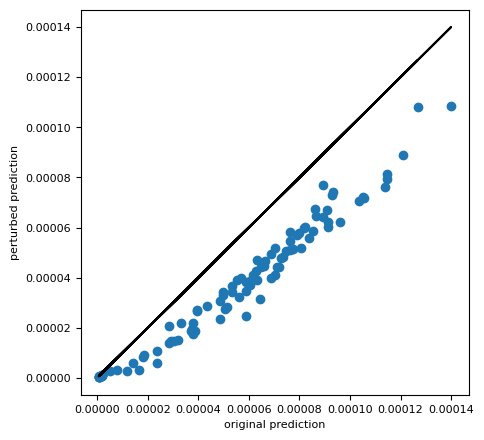

In [28]:
predicted_changes, samples_of_interest = model.gene2peak(gene_name=gene_name, testset=testset, plot=True)

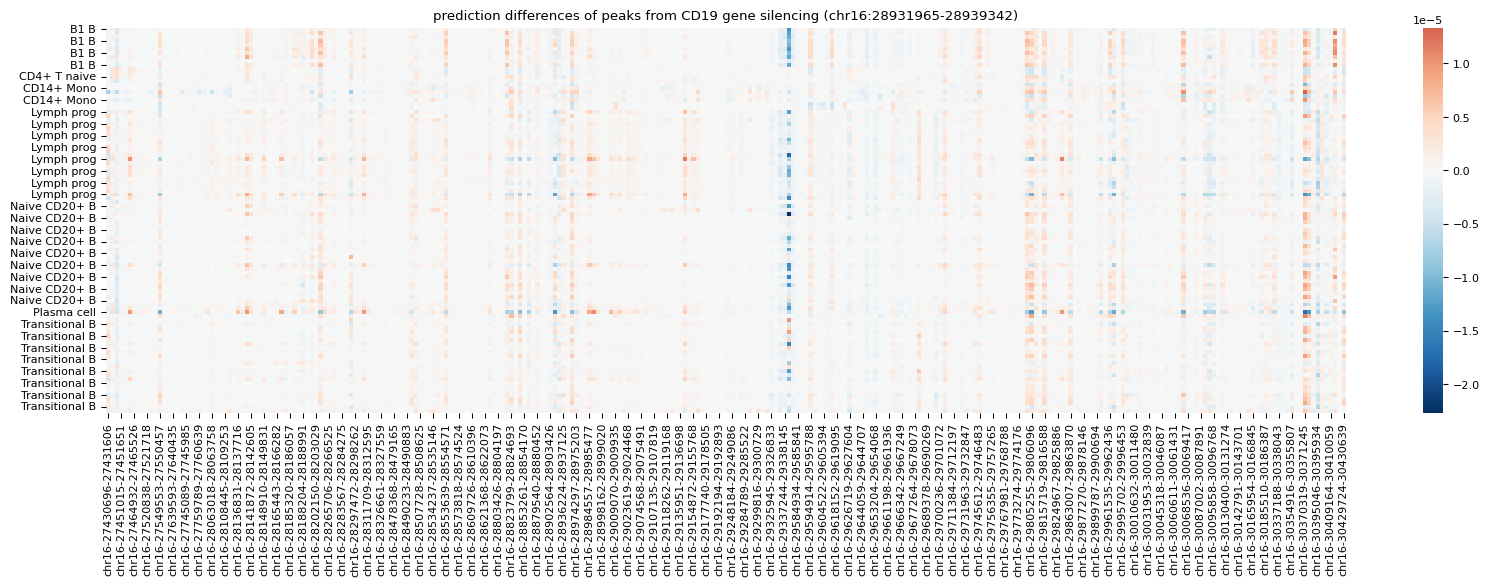

In [29]:
gene_chromosome = gene_location.split(":")[0]
window_start = int(gene_location.split(":")[1].split("-")[0]) - 1500000
window_end = int(gene_location.split(":")[1].split("-")[1]) + 1500000
# find the closest start and end peaks to the window start and end
start_peak, end_peak = find_closest_start_and_end(gene_chromosome, window_start, window_end)

cell_types = testset.obs['cell_type'].values[samples_of_interest]
heatmap_1 = predicted_changes[1][:,start_peak:end_peak]

df_heatmap_1 = plot_gel(heatmap_1, gene_name, gene_location)
cell_types_unique, cell_types_numbers = df_heatmap_1.index.value_counts().index.values, df_heatmap_1.index.value_counts().values

In [30]:
def prepare_df_emma(file_dir):
    df_emma = pd.read_csv(file_dir, sep=",")
    sample_names = df_emma.sample_name.unique()
    # average the positive controls
    df_pos = df_emma[df_emma.sample_name != 'HCASMC_HiChIP_H3K27ac']
    df_pos = df_pos.groupby(['position']).mean().reset_index()
    df_pos['sample_name'] = 'positive'
    df_pos = df_pos[['position', 'EIS', 'sample_name']]
    df_neg = df_emma[df_emma.sample_name == 'HCASMC_HiChIP_H3K27ac']
    df_neg['sample_name'] = 'negative'
    df_neg = df_neg[['position', 'EIS', 'sample_name']]
    df_emma_out = pd.concat([df_pos, df_neg])
    df_emma_out.columns = ['position', 'signal', 'cell type']
    df_emma_out['std'] = 0
    df_emma_out['method'] = 'HiChIP'
    return df_emma_out

In [31]:
# plot the response in emma's window per cell type

window_size = 10000

df_hichip = prepare_df_emma(file_dir)
df_pos_intersect = np.sort(df_hichip['position'].unique())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = insilico_hichip(df_heatmap_1, [ct], bins=df_pos_intersect, window_size=window_size, norm=False, use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'multiDGD'
    })
    if i == 0:
        df_open_closed = df_open_closed_temp
    else:
        df_open_closed = pd.concat([df_open_closed, df_open_closed_temp], axis=0)

df_open_closed = pd.concat([df_open_closed, df_hichip], axis=0)
df_open_closed['position'] = df_open_closed['position'].values / 1e6
print(df_hichip['cell type'].unique())

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_18862/1951223608.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pos = df_pos.groupby(['position']).mean().reset_index()
/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_18862/1951223608.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['sample_name'] = 'negative'


['positive' 'negative']


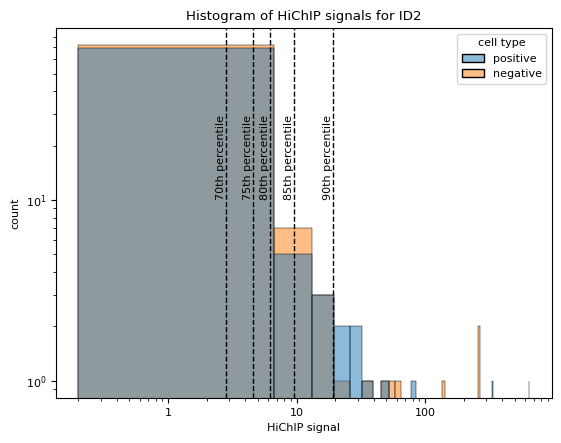

In [42]:
# plot histograms of the hichip values
from matplotlib.ticker import ScalarFormatter

sns.histplot(data=df_open_closed[df_open_closed['method']=='HiChIP'], x='signal', hue='cell type', bins=100, alpha=0.5)
# add lines for some percentiles
percentiles = [70, 75, 80, 85, 90]
for p in percentiles:
    plt.axvline(x=np.percentile(df_open_closed[df_open_closed['method']=='HiChIP']['signal'], p), color='black', linestyle='--', lw=1)
    plt.text(np.percentile(df_open_closed[df_open_closed['method']=='HiChIP']['signal'], p), 10, str(p)+'th percentile', rotation=90, va='bottom', ha='right')
plt.yscale('log')
plt.xscale('log')
# make the axis ticks normal numbers instead of scientific notation
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('HiChIP signal')
plt.ylabel('count')
plt.title('Histogram of HiChIP signals for ID2')
plt.show()

In [45]:
# reindex the dataframe
df_open_closed.reset_index(inplace=True, drop=True)

# get the 75th percentile of the hichip signals to have something to compare to for binarized data
df_open_closed_hichip = df_open_closed[df_open_closed['method']=='HiChIP'].copy()
thresh_hichip = df_open_closed_hichip['signal'].quantile(0.85)
print(thresh_hichip)

df_pos_intersect = np.sort(df_open_closed['position'].unique())

# now subset the data to these positions
#df_open_closed_hichip = df_open_closed_hichip[df_open_closed_hichip['position'].isin(df_pos_intersect)]

# now binarize the data
df_open_closed_binary_hichip = df_open_closed_hichip.copy()
df_open_closed_binary_hichip['signal'] = df_open_closed_binary_hichip['signal'].apply(lambda x: 1 if x > thresh_hichip else 0)
df_open_closed_binary_dgd = df_open_closed[df_open_closed['method']=='multiDGD'].copy()
# select the valid positions
#df_open_closed_binary_dgd = df_open_closed_binary_dgd[df_open_closed_binary_dgd['position'].isin(df_pos_intersect)]

9.585316138781725


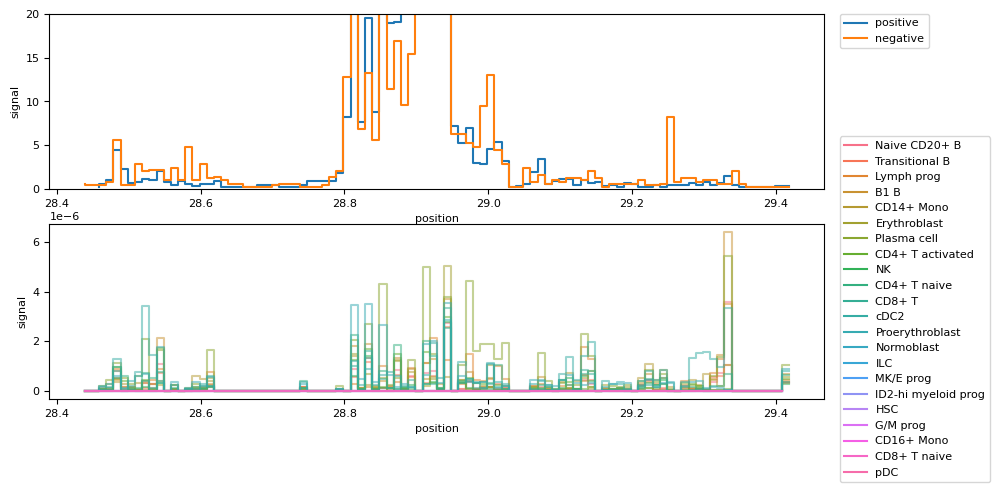

In [34]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
sns.lineplot(x='position', y='signal', data=df_open_closed[df_open_closed['method']=='HiChIP'], hue='cell type', ax=ax[0], drawstyle='steps-pre')
ax[0].set_ylim(0,20)
ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0.)
sns.lineplot(x='position', y='signal', data=df_open_closed[df_open_closed['method']=='multiDGD'], hue='cell type', ax=ax[1], alpha=0.5, drawstyle='steps-pre')
ax[1].legend(bbox_to_anchor=(1.02, 1.5), loc=2, borderaxespad=0.)
plt.show()

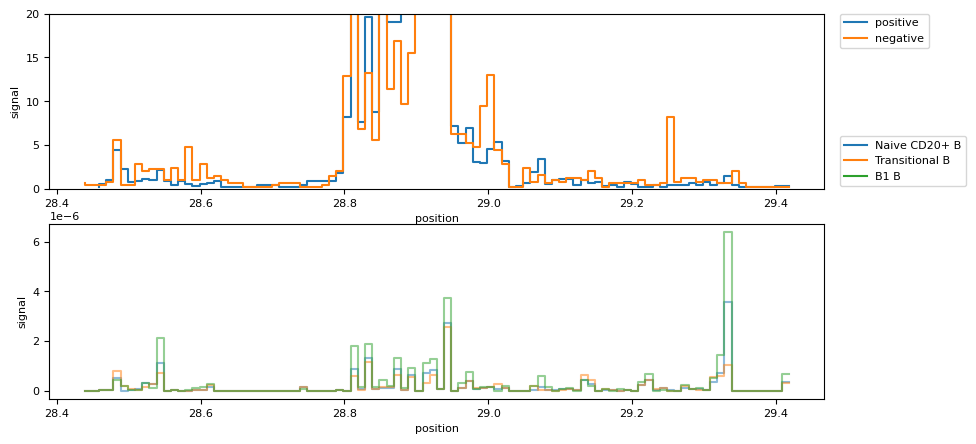

In [35]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
sns.lineplot(x='position', y='signal', data=df_open_closed[df_open_closed['method']=='HiChIP'], hue='cell type', ax=ax[0], drawstyle='steps-pre')
ax[0].set_ylim(0,20)
ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0.)
sns.lineplot(x='position', y='signal', data=df_open_closed[(df_open_closed['method']=='multiDGD')&(df_open_closed['cell type'].isin(['Naive CD20+ B', 'Transitional B', 'B1 B']))], hue='cell type', ax=ax[1], alpha=0.5, drawstyle='steps-pre')
ax[1].legend(bbox_to_anchor=(1.02, 1.5), loc=2, borderaxespad=0.)
plt.show()

In [37]:
df_open_closed['cell type'].unique()

array(['Naive CD20+ B', 'Transitional B', 'Lymph prog', 'B1 B',
       'CD14+ Mono', 'Erythroblast', 'Plasma cell', 'CD4+ T activated',
       'NK', 'CD4+ T naive', 'CD8+ T', 'cDC2', 'Proerythroblast',
       'Normoblast', 'ILC', 'MK/E prog', 'ID2-hi myeloid prog', 'HSC',
       'G/M prog', 'CD16+ Mono', 'CD8+ T naive', 'pDC',
       'HCASMC_HiChIP_H3K27ac_G1', 'HCASMC_HiChIP_H3K27ac_G2',
       'HCASMC_HiChIP_H3K27ac'], dtype=object)

In [ ]:
# save the dataframe
df_open_closed.to_csv('./results/analysis/analysis_referencedata/'+gene_name+'_hg38_hichip_dgd_aligned_locations.csv', index=False)

In [36]:
def plot_roc_curves(df_c, df_p, c_1, c_2, p_1, p_2):
    # now make ROC curves for the dgd predictions
    from sklearn.metrics import roc_curve, auc

    pos_color = 'cornflowerblue'
    neg_color = 'lightcoral'
    correction_color = 'slategray'

    # drop duplicates
    df_c = df_c.drop_duplicates()
    df_p = df_p.drop_duplicates()

    #print(df_c)
    #print(df_p)

    # create 2 subplots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    # adjust spacing
    fig.subplots_adjust(wspace=0.9)

    # first get the values for the same positions
    x, y = df_c[df_c['cell type']==c_1], df_p[df_p['cell type']==p_1]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    ax[0].plot(fpr, tpr, pos_color, label=f'HiChIP B cell lymphoblast\nAUPRC = {np.round(auprc, 3)}')

    x, y = df_c[df_c['cell type']==c_2], df_p[df_p['cell type']==p_1]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, neg_color, label=f'HiChIP HCASMC (neg control)\nAUPRC = {np.round(auprc, 3)}')
    ax[0].axline((min(fpr), min(tpr)), slope=1, color="grey", linestyle=':')
    ax[0].set_xlabel("False positive rate")
    ax[0].set_ylabel("True positive rate")
    ax[0].set_title("DGD prediction (CD20+ Naive B cell)")
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)


    x, y = df_c[df_c['cell type']==c_1], df_p[df_p['cell type']==p_2]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, pos_color, label=f'HiChIP B cell lymphoblast\nAUPRC = {np.round(auprc, 3)}')
    
    x, y = df_c[df_c['cell type']==c_2], df_p[df_p['cell type']==p_2]
    intersect = list(set(x['position'].values).intersection(set(y['position'].values)))
    x, y = x[x['position'].isin(intersect)]['signal'], y[y['position'].isin(intersect)]['signal']
    fpr, tpr, thresholds =  roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, neg_color, label=f'HiChIP HCASMC (neg control)\nAUPRC = {np.round(auprc, 3)}')
    ax[1].axline((min(fpr), min(tpr)), slope=1, color="grey", linestyle=':')
    ax[1].set_xlabel("False positive rate")
    ax[1].set_ylabel("True positive rate")
    ax[1].set_title("DGD prediction (CD14+ Monocytes)")
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)
    plt.show()

    return optimal_threshold

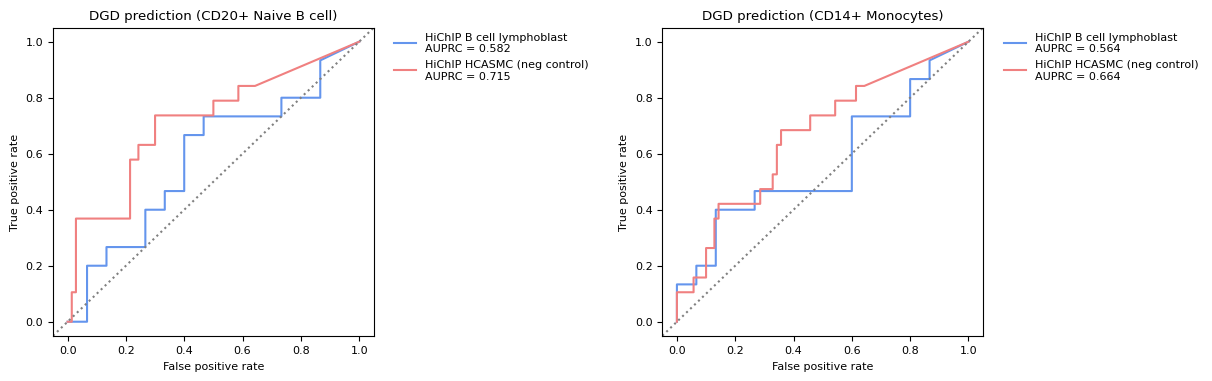

In [73]:
# threshold 0.7
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'Naive CD20+ B', 'CD14+ Mono')

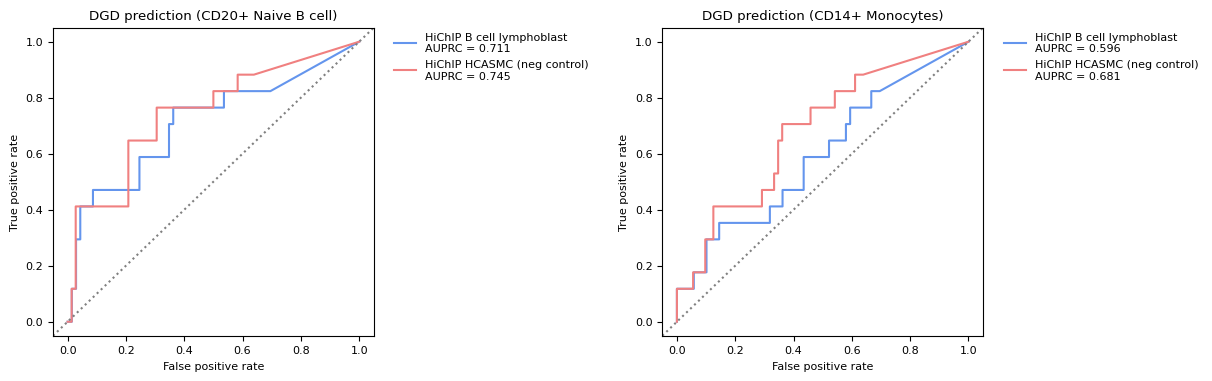

In [43]:
# 0.8
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'Naive CD20+ B', 'CD14+ Mono')

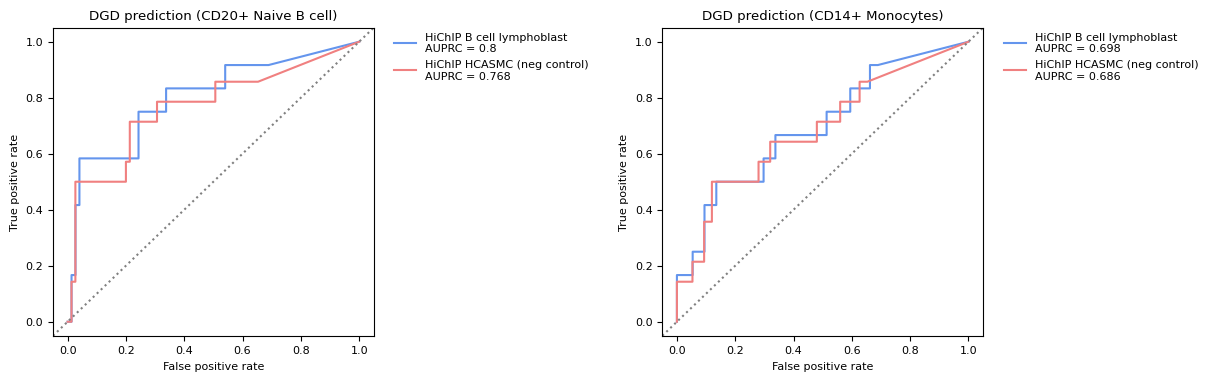

In [46]:
# 0.85
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'Naive CD20+ B', 'CD14+ Mono')

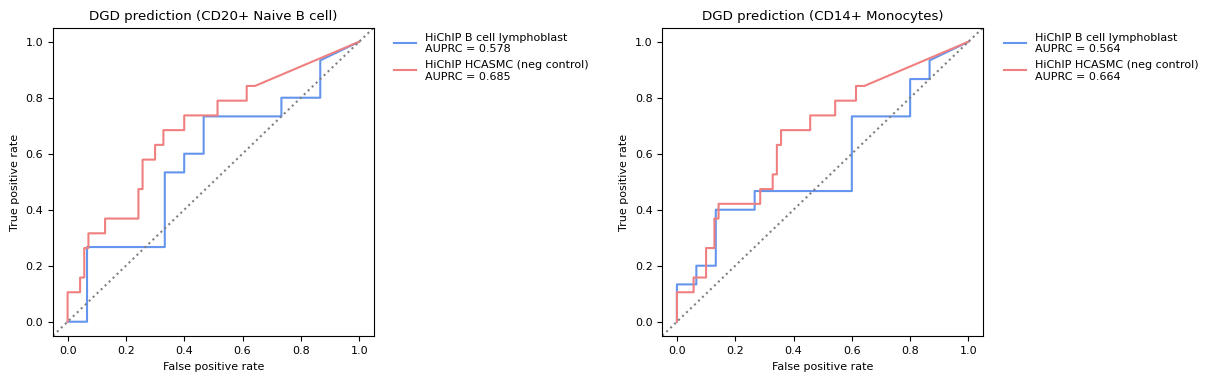

In [74]:
# threshold 0.7
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'Transitional B', 'CD14+ Mono')

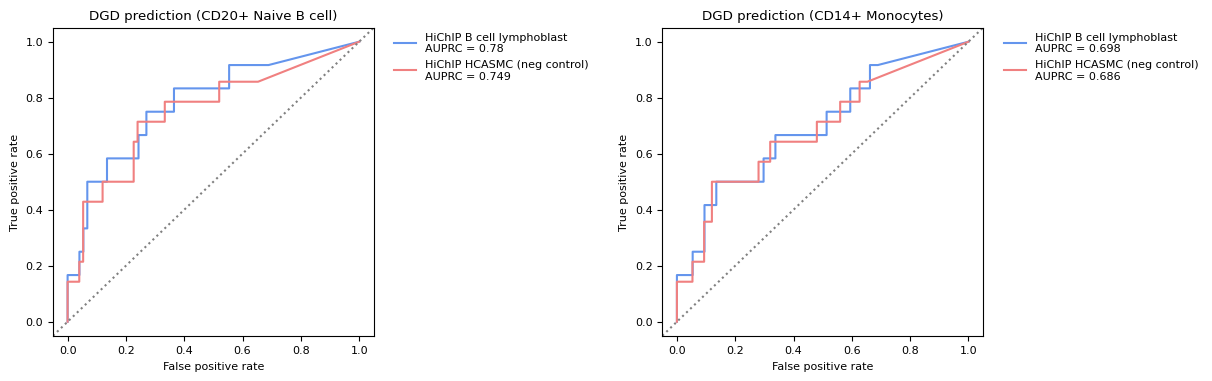

In [47]:
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'Transitional B', 'CD14+ Mono')

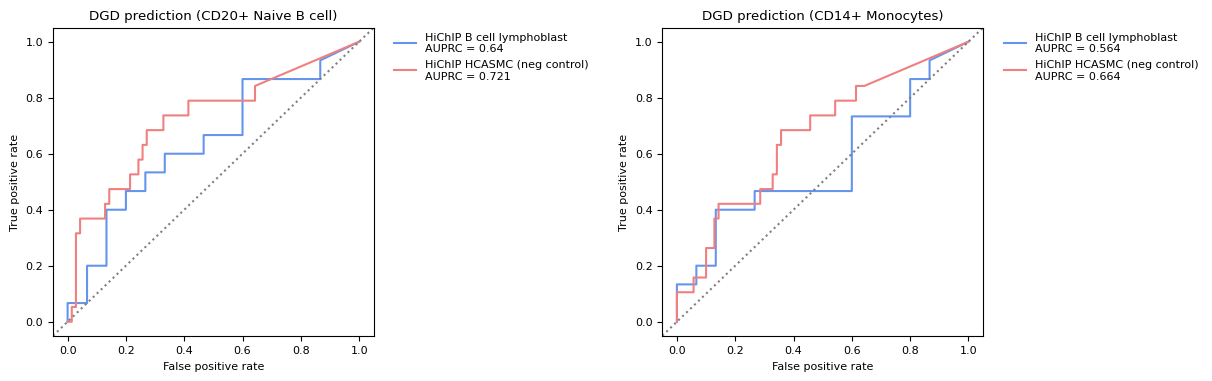

In [75]:
# threshold 0.7
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'B1 B', 'CD14+ Mono')

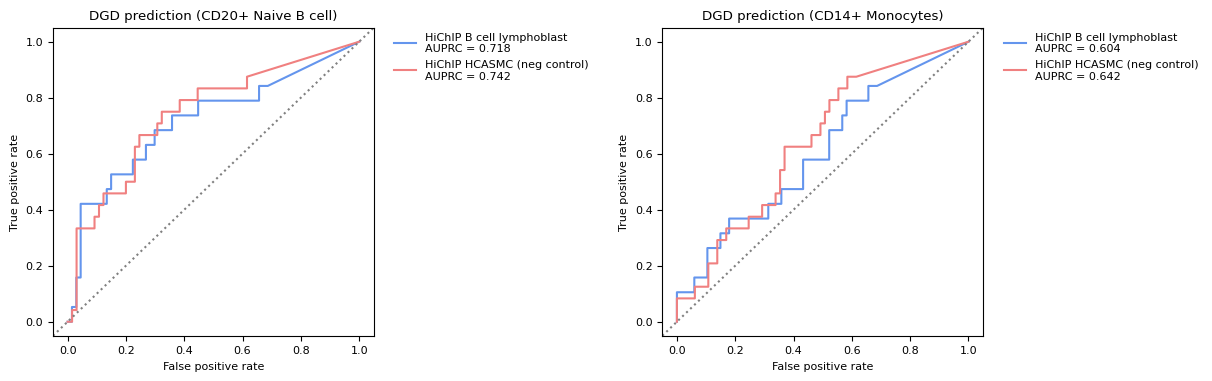

1.3626934958210768e-07

In [39]:
#threshold 0.75
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'B1 B', 'CD14+ Mono')
optimal_threshold

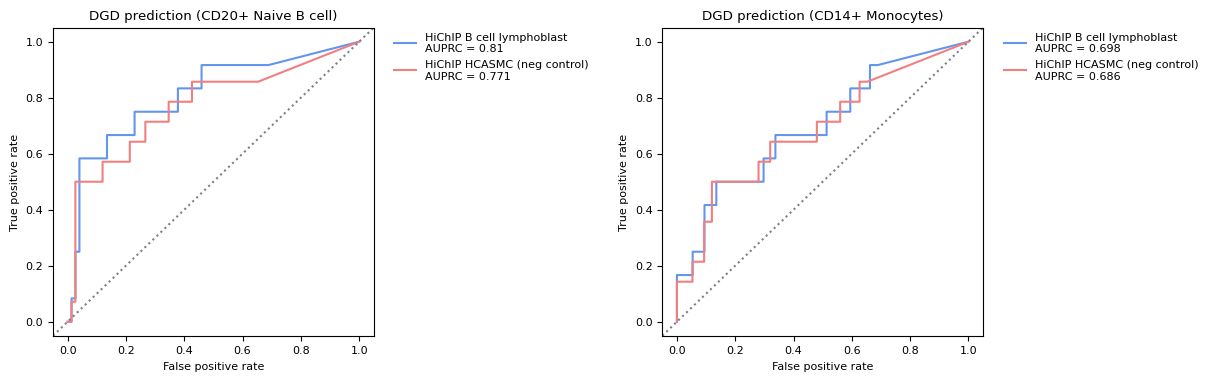

9.012211421577376e-07

In [48]:
# threshold 0.85
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'B1 B', 'CD14+ Mono')
optimal_threshold

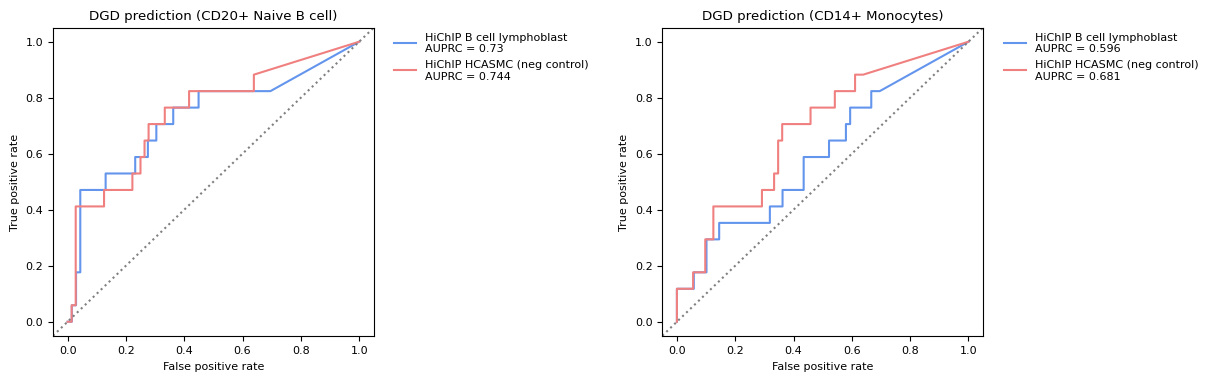

7.533708720567726e-07

In [41]:
# threshold 0.8
optimal_threshold = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_binary_dgd, 'positive', 'negative', 'B1 B', 'CD14+ Mono')
optimal_threshold

In [199]:
def plot_histograms(df, p_1, p_2, ylims, xlims):
    gene_start = int(gene_location.split(":")[1].split("-")[0])/1e6
    gene_end = int(gene_location.split(":")[1].split("-")[1])/1e6
    thresh_dgd = optimal_threshold
    thresholds = [thresh_hichip, thresh_hichip, thresh_dgd, thresh_dgd]
    #ylims = [15,15,3e-6,3e-6]
    #ylims = [20,20,1e-5,1e-5]
    ylabels = ['EIS','EIS','|Δ prediction|', '|Δ prediction|']
    color_pos = 'cornflowerblue'
    color_neg = 'slategray'
    gene_color = 'coral'
    gene_alpha = 1

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,6))
    # adjust spacing
    fig.subplots_adjust(hspace=0.7)

    ax[0].fill_between(
        df[(df['method']=='HiChIP')&(df['cell type']=='negative')]['position'],
        df[(df['method']=='HiChIP')&(df['cell type']=='negative')]['signal'],
        step="pre", color=color_neg, alpha=1, lw=2)
    ax[0].set_title('HiChIP negative control (muscle cell line)')


    ax[1].fill_between(
        df[(df['method']=='HiChIP')&(df['cell type']=='positive')]['position'],
        df[(df['method']=='HiChIP')&(df['cell type']=='positive')]['signal'],
        step="pre", color=color_pos, alpha=1, lw=2)
    ax[1].set_title('HiChIP positive control (B cell lymphoblast)')

    ax[2].fill_between(
        df[(df['method']=='multiDGD')&(df['cell type']==p_1)]['position'],
        df[(df['method']=='multiDGD')&(df['cell type']==p_1)]['signal'],
        step="pre", color=color_pos, alpha=1, lw=2)
    ax[2].set_title('DGD positive control ('+p_1+')')

    ax[3].fill_between(
        df[(df['method']=='multiDGD')&(df['cell type']==p_2)]['position'],
        df[(df['method']=='multiDGD')&(df['cell type']==p_2)]['signal'],
        step="pre", color=color_neg, alpha=1, lw=2)
    ax[3].set_title('DGD negative control (CD14+ monocyte)')

    for i in range(4):
        #ax[i].set_yscale('log')
        ax[i].set_xlim(xlims[0],xlims[1])
        ax[i].axvline(x=gene_start, color=gene_color, linestyle='--', lw=1, label=gene_name+' genomic location')
        ax[i].axvline(x=gene_end, color=gene_color, linestyle='--', lw=1)
        ax[i].set_ylim(0,ylims[i])
        ax[i].axhline(y=thresholds[i], color='black', linestyle='--', lw=1, label='binary threshold')
        ax[i].set_ylabel(ylabels[i])
        if i < 3:
            ax[i].set_xlabel('')
        else:
            ax[3].set_xlabel('genomic coordinate (Mb) on chromosome '+gene_location.split(":")[0].split("chr")[1])

    ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0., frameon=False)

    #caption = 'In silico gene-to-peak linkage of ID2'
    #fig.text(.51, 1.005, caption, ha='center', fontsize=10, fontweight='bold')

    plt.show()

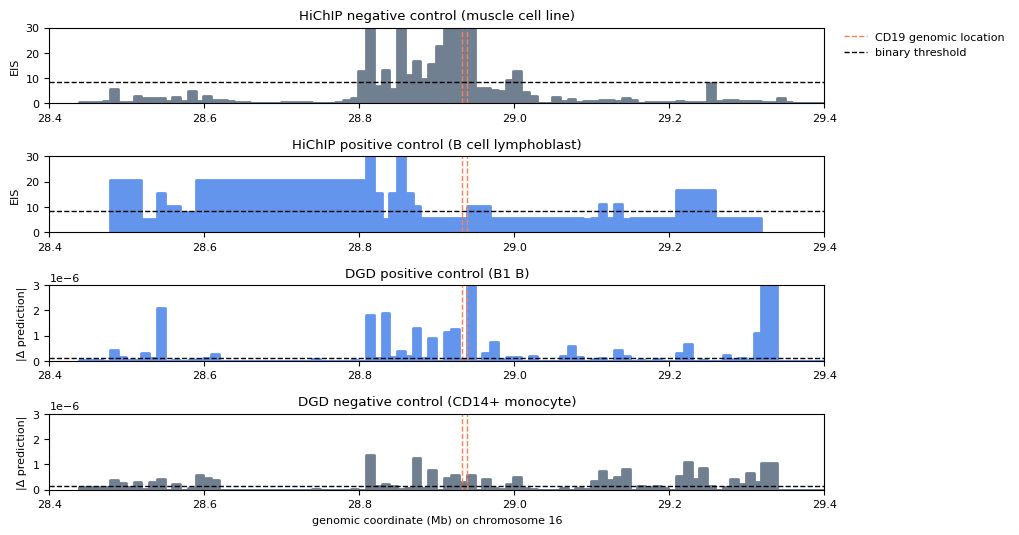

In [102]:
plot_histograms(df_open_closed, 'B1 B', 'CD14+ Mono', [30,30,3e-6,3e-6], [28.4,29.4])

#### baseline correlation

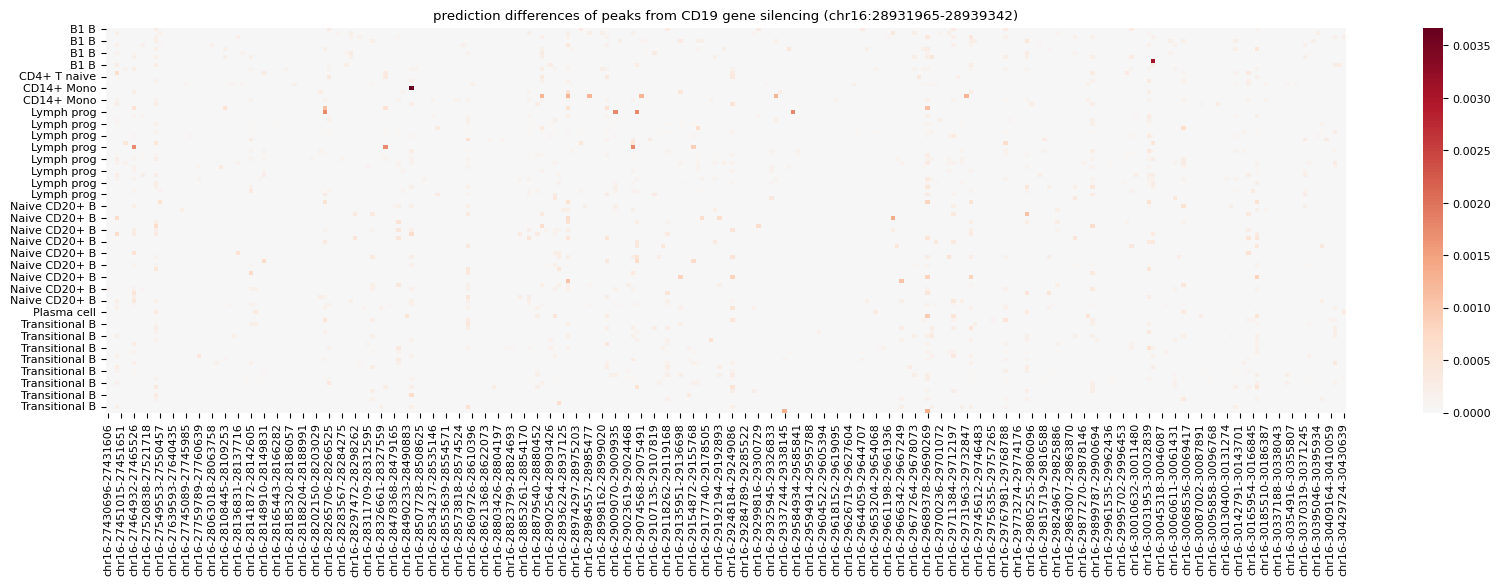

In [200]:
# now for normalized cell counts (divided by count depth of cell)

gex_count_depth = testset.obs['GEX_n_counts'].values[samples_of_interest]
atac_count_depth = testset.obs['ATAC_nCount_peaks'].values[samples_of_interest]

heatmap_control = torch.tensor(np.array(testset.X[samples_of_interest, start_peak:end_peak].todense())) / torch.tensor(atac_count_depth).unsqueeze(1)
df_heatmap_control = plot_gel(heatmap_control, gene_name, gene_location)

In [201]:
gene_counts = np.array(testset.X[samples_of_interest, gene_idx].todense())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = gene_correlation(
        gene_counts[np.where(testset[samples_of_interest].obs['cell_type'] == ct)[0]], 
        df_heatmap_control, 
        [ct], 
        bins=df_pos_intersect*1e6, 
        window_size=window_size, 
        norm=False, 
        use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'Spearman'
    })
    if i == 0:
        df_open_closed_control = df_open_closed_temp
    else:
        df_open_closed_control = pd.concat([df_open_closed_control, df_open_closed_temp], axis=0)

df_open_closed_control
df_open_closed_control.index = np.arange(len(df_open_closed_control))
df_open_closed_control['position'] = df_open_closed_control['position'] / 1e6

/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the

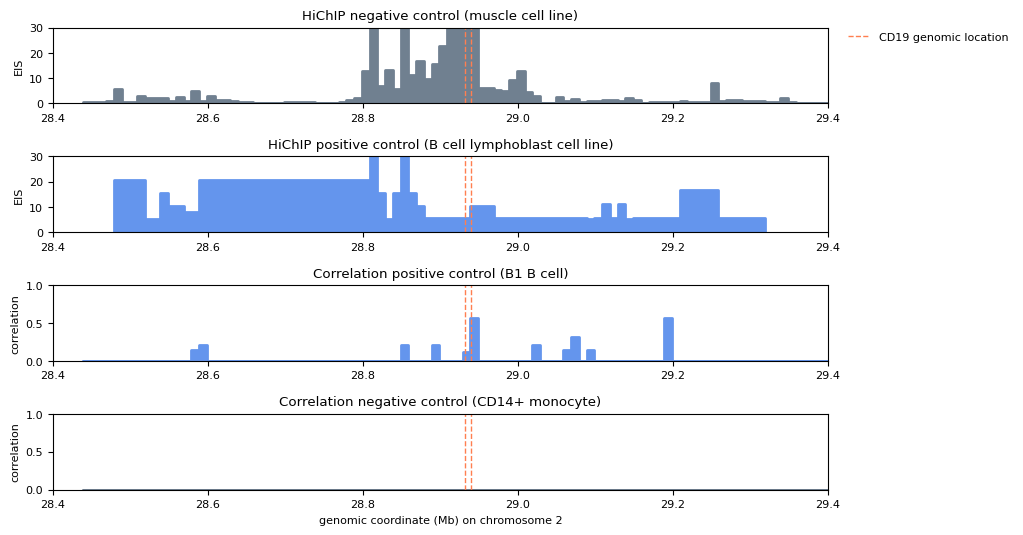

In [109]:
# create a plot of the open/closed regions in df_open_closed
# with two subplots underneath each other
# the first one will be the hichip signals
# the second one the multiDGD predictions
gene_start = int(gene_location.split(":")[1].split("-")[0])/1e6
gene_end = int(gene_location.split(":")[1].split("-")[1])/1e6
ylims = [30,30,1,1]
ylabels = ['EIS','EIS','correlation', 'correlation']
color_pos = 'cornflowerblue'
color_neg = 'slategray'
gene_color = 'coral'
gene_alpha = 1

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,6))
# adjust spacing
fig.subplots_adjust(hspace=0.7)

ax[0].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='negative')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='negative')]['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[0].set_title('HiChIP negative control (muscle cell line)')


ax[1].fill_between(
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='positive')]['position'],
    df_open_closed[(df_open_closed['method']=='HiChIP')&(df_open_closed['cell type']=='positive')]['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[1].set_title('HiChIP positive control (B cell lymphoblast cell line)')

ax[2].fill_between(
    df_open_closed_control[df_open_closed_control['cell type']=='B1 B']['position'],
    df_open_closed_control[df_open_closed_control['cell type']=='B1 B']['signal'],
    step="pre", color=color_pos, alpha=1, lw=2)
ax[2].set_title('Correlation positive control (B1 B cell)')

ax[3].fill_between(
    df_open_closed_control[df_open_closed_control['cell type']=='CD14+ Mono']['position'],
    df_open_closed_control[df_open_closed_control['cell type']=='CD14+ Mono']['signal'],
    step="pre", color=color_neg, alpha=1, lw=2)
ax[3].set_title('Correlation negative control (CD14+ monocyte)')

for i in range(4):
    #ax[i].set_yscale('log')
    ax[i].set_xlim(28.4,29.4)
    ax[i].axvline(x=gene_start, color=gene_color, linestyle='--', lw=1, label=gene_name+' genomic location')
    ax[i].axvline(x=gene_end, color=gene_color, linestyle='--', lw=1)
    ax[i].set_ylim(0,ylims[i])
    #ax[i].axhline(y=thresholds[i], color='black', linestyle='--', lw=1, label='binary threshold')
    ax[i].set_ylabel(ylabels[i])
    if i < 3:
        ax[i].set_xlabel('')
    else:
        ax[3].set_xlabel('genomic coordinate (Mb) on chromosome 2')

ax[0].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0., frameon=False)

#caption = 'In silico gene-to-peak linkage of ID2'
#fig.text(.51, 1.005, caption, ha='center', fontsize=10, fontweight='bold')

plt.show()

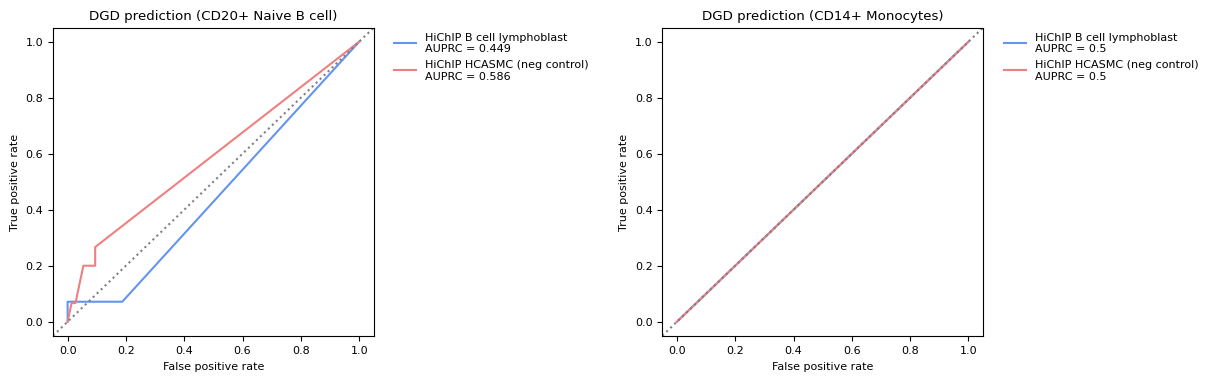

In [202]:
df_open_closed_control.fillna(0, inplace=True)

_ = plot_roc_curves(df_open_closed_binary_hichip, df_open_closed_control, 'positive', 'negative', 'B1 B', 'CD14+ Mono')

## comparison

In [47]:
df_auc = pd.read_csv("./results/analysis/analysis_referencedata/gene2peak_evaluation.csv", sep=";", decimal=',')

In [48]:
df_auc['sample'] = ['HiChIP ' + df_auc['control_type'].values[i] + ', data ' + df_auc['cell_type'].values[i] for i in range(len(df_auc))]

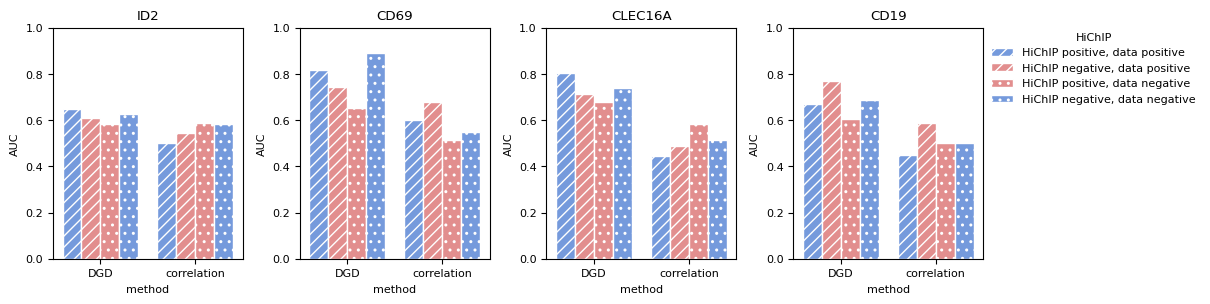

In [49]:
# make a figure with a subplot for each gene
# each subplot should be a seaborn bar plot of the AUC against the methods colored by the control type
# we will for now only look at the positive cell_type rows

#palette = ['cornflowerblue', 'goldenrod', 'lightcoral', 'slategray']
palette = ['cornflowerblue', 'lightcoral', 'lightcoral', 'cornflowerblue']
import itertools
#hatches = itertools.cycle(['///', '..', 'xx', '|||'])
hatches = itertools.cycle(['///', '///', '..', '..'])

gene_names = df_auc['gene'].unique()
n_genes = len(gene_names)
fig, ax = plt.subplots(nrows=1, ncols=n_genes, figsize=(3*n_genes,3))
# adjust spacing
fig.subplots_adjust(wspace=0.3)
for i, name in enumerate(gene_names):
    ax[i].set_title(name)
    df_temp = df_auc[(df_auc['gene']==name)]
    sns.barplot(x='method', y='AUC', hue='sample', data=df_temp, ax=ax[i], palette=palette, edgecolor='white')
    ax[i].set_ylim(0,1)
    #num_locations = len(df_auc['sample'].unique())
    #for j, bar in enumerate(ax[i].patches):
    #    if j % num_locations == 0:
    #        hatch = next(hatches)
    #    bar.set_hatch(hatch)
    for bars, hatch in zip(ax[i].containers, hatches):
        # Set a different hatch for each group of bars
        for bar in bars:
            bar.set_hatch(hatch)
    if i == n_genes-1:
        ax[i].legend(bbox_to_anchor=(1.02, 1.), loc=2, borderaxespad=0., frameon=False, title='HiChIP')
    else:
        ax[i].get_legend().remove()
plt.show()
